In [372]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from chatgpt_util_imports import generate_dataset
from data_util import clean_data, onehot_decode, onehot_encode, PatchDataset
from models import VAE, AE
from train import collect_embeddings, load_checkpoint, print_loss_metrics, save_checkpoint, train_one_epoch, validate
from util import get_date_and_time

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [373]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [376]:
# Load +31k patches as compiled by `bwhitman` for `learnfm`.
fpath = 'data/compact.bin'

df = generate_dataset(fpath)
df = pd.DataFrame(df)
df = clean_data(df)
df = onehot_encode(df)

dataset = PatchDataset(df)

print(f"Num patches: {dataset.df.shape[0]}")
print(f"Num features: {dataset.df.shape[1]}")

Num patches: 30810
Num features: 227


OP6 EG rate 1


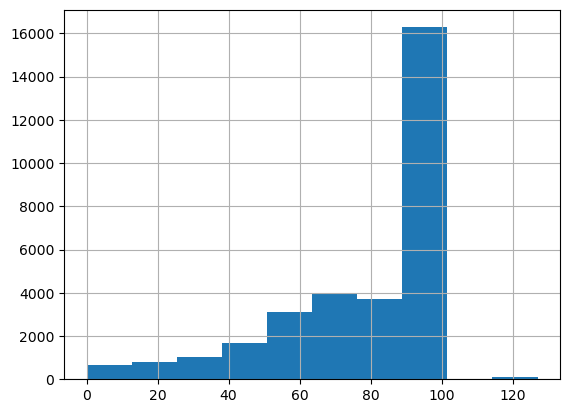

OP6 EG rate 2


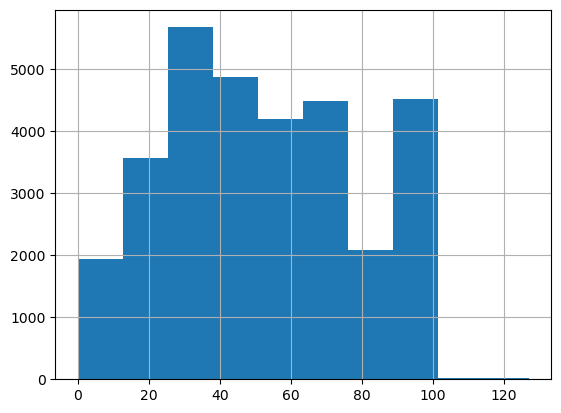

OP6 EG rate 3


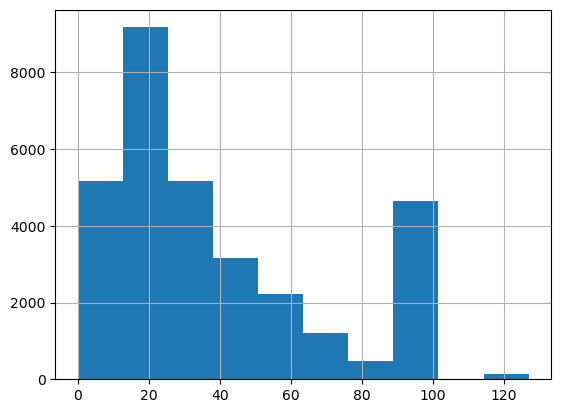

OP6 EG rate 4


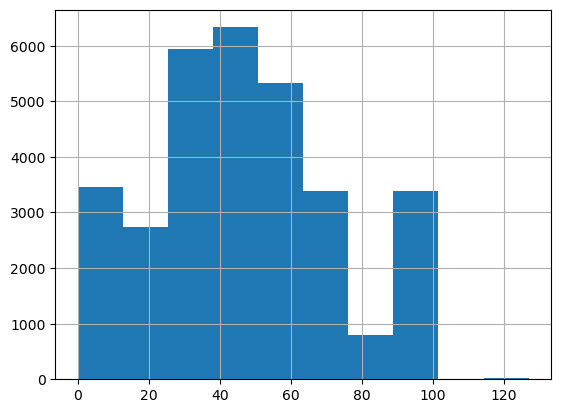

OP6 EG level 1


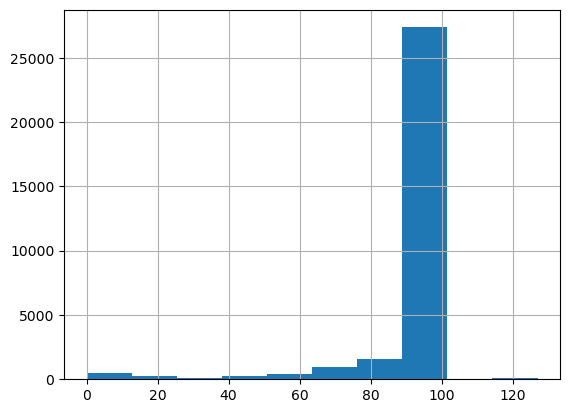

OP6 EG level 2


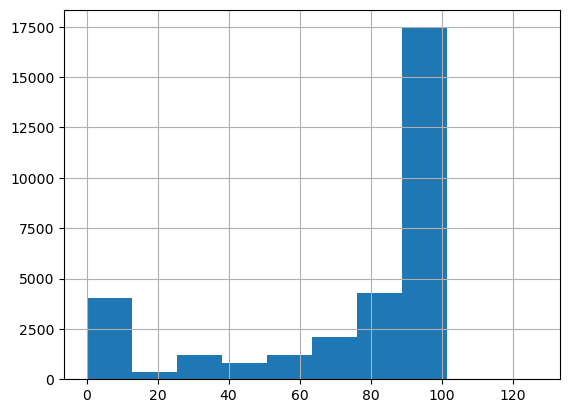

OP6 EG level 3


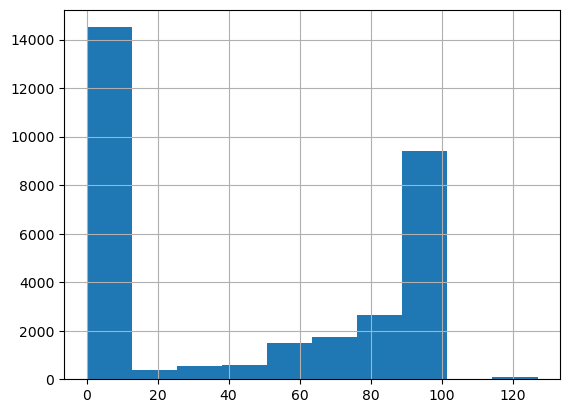

OP6 EG level 4


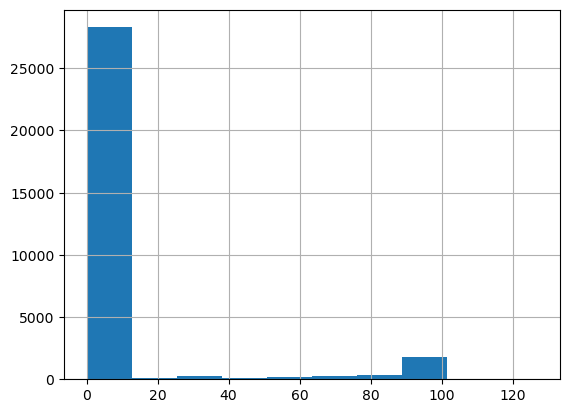

OP6 KBD LEV SCL BRK PT


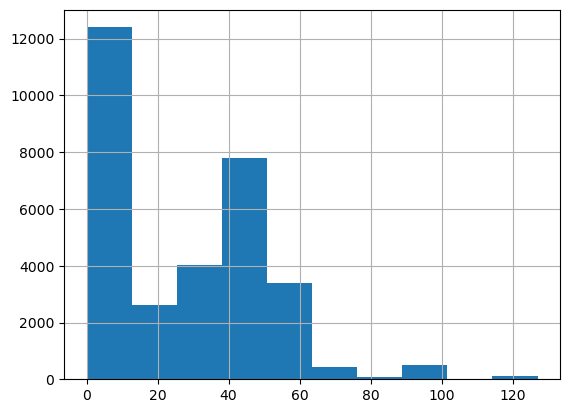

OP6 KBD LEV SCL LFT DEPTH


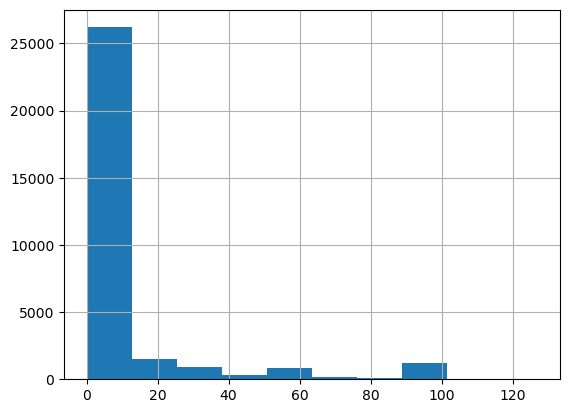

OP6 KBD LEV SCL RHT DEPTH


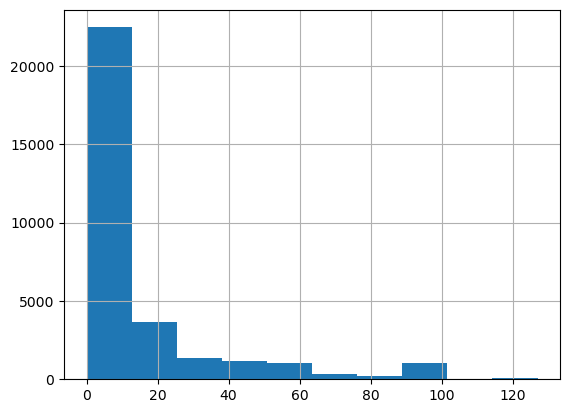

OP6 KBD LEV SCL LFT CURVE


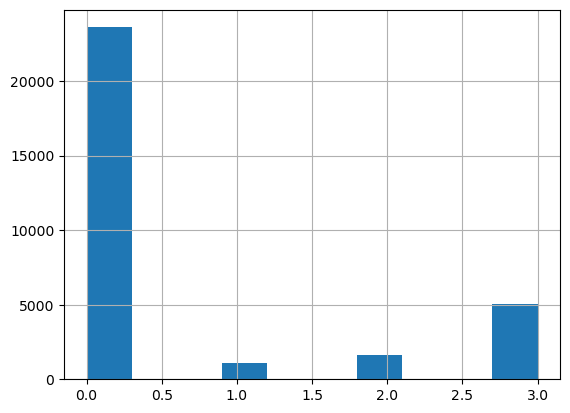

OP6 KBD LEV SCL RHT CURVE


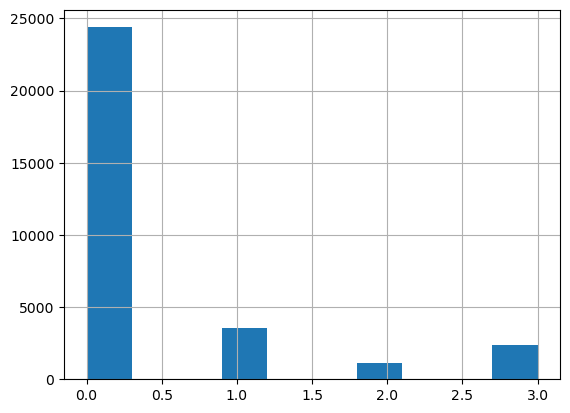

OP6 OSC DETUNE


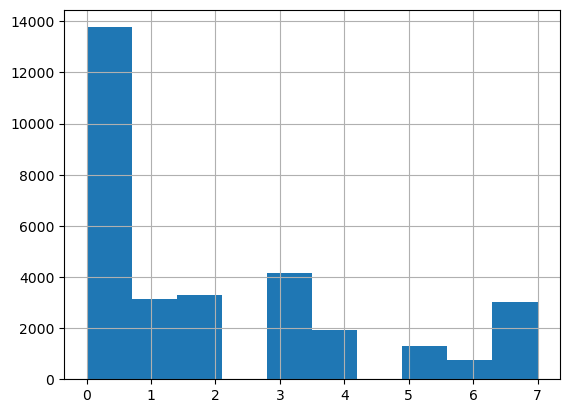

OP6 KBD RATE SCALING


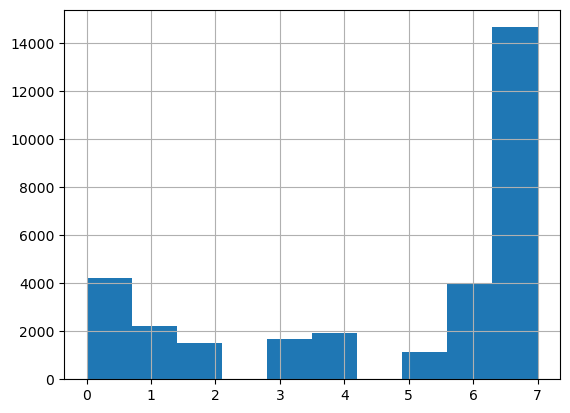

OP6 KEY VEL SENSITIVITY


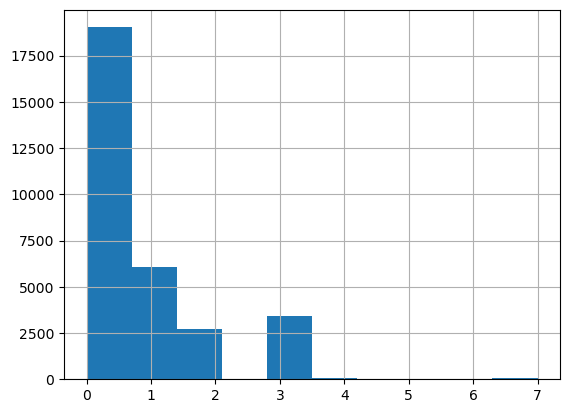

OP6 AMP MOD SENSITIVITY


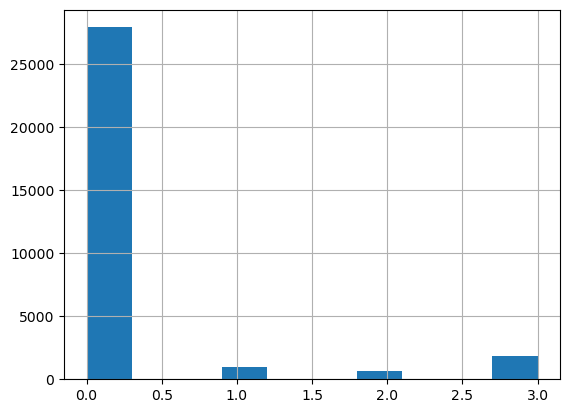

OP6 OPERATOR OUTPUT LEVEL


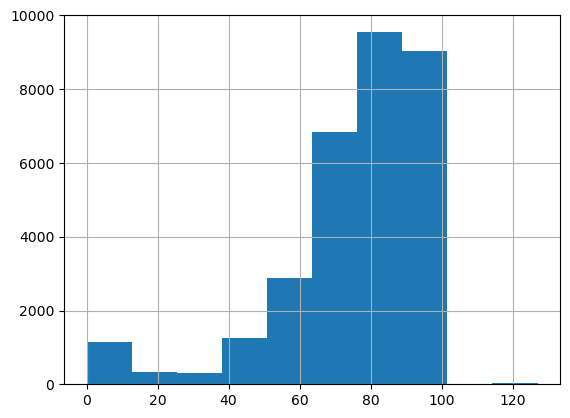

OP6 OSC MODE


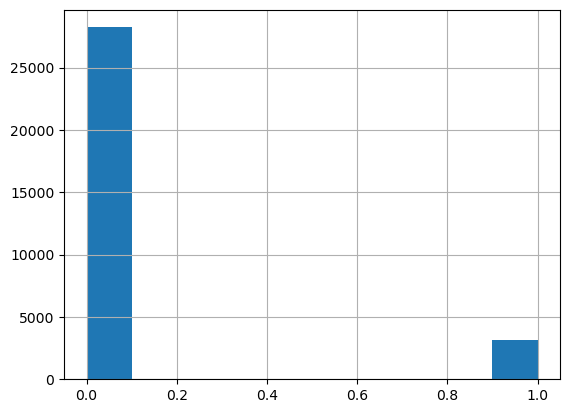

OP6 OSC FREQ COARSE


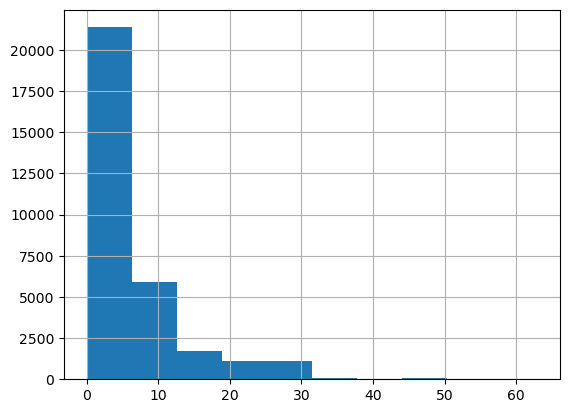

OP6 OSC FREQ FINE


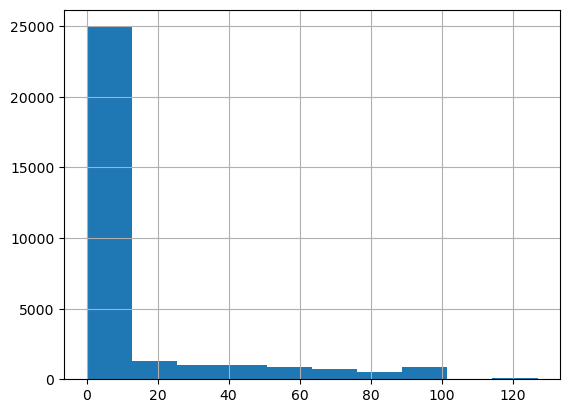

OP5 EG rate 1


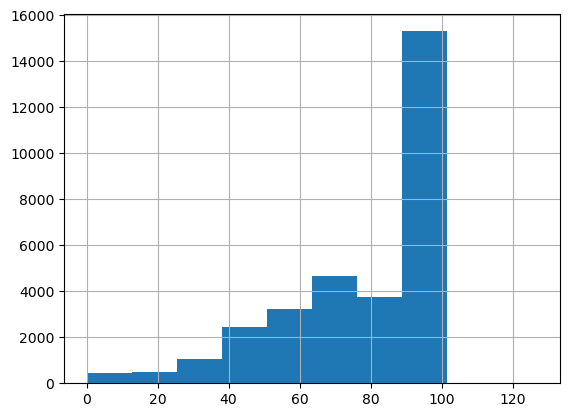

OP5 EG rate 2


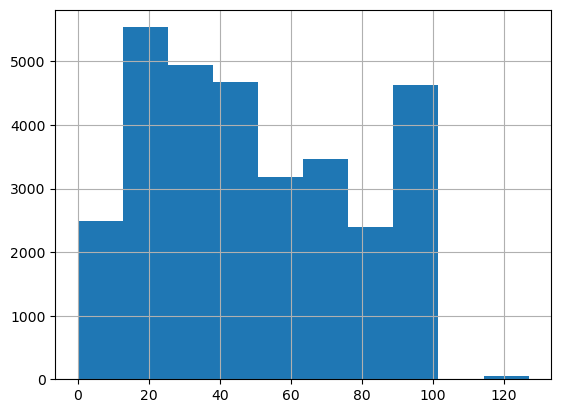

OP5 EG rate 3


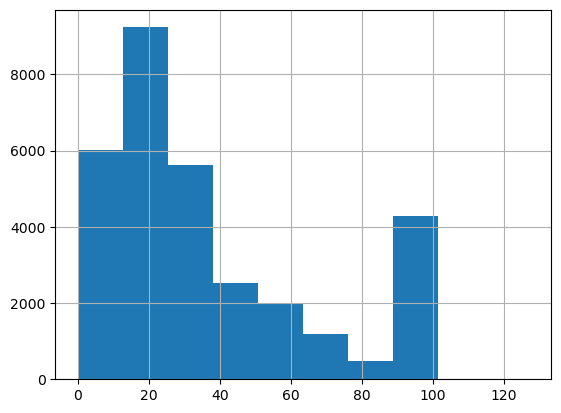

OP5 EG rate 4


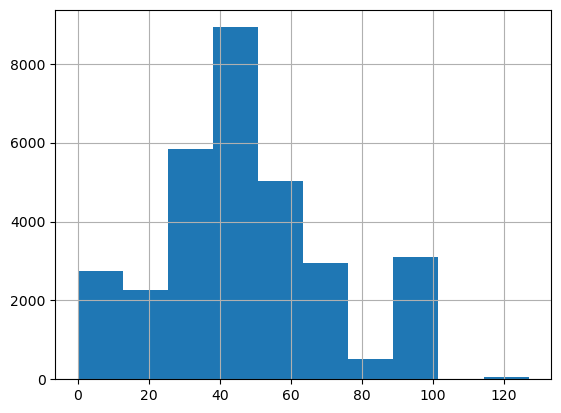

OP5 EG level 1


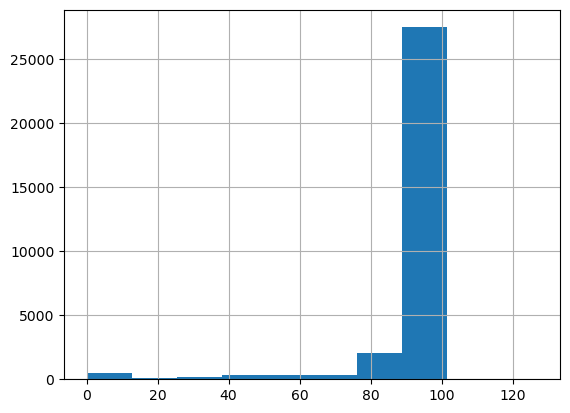

OP5 EG level 2


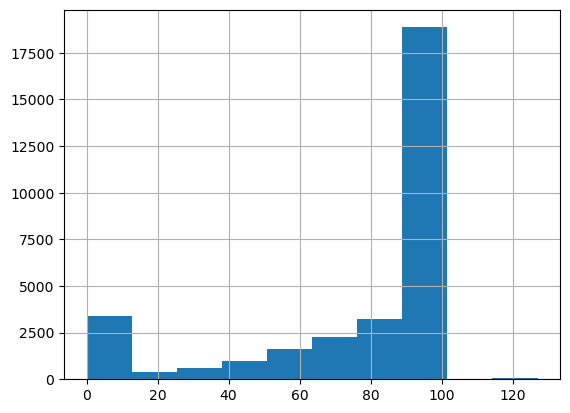

OP5 EG level 3


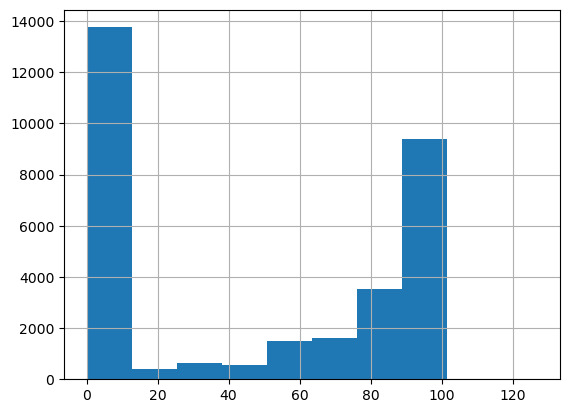

OP5 EG level 4


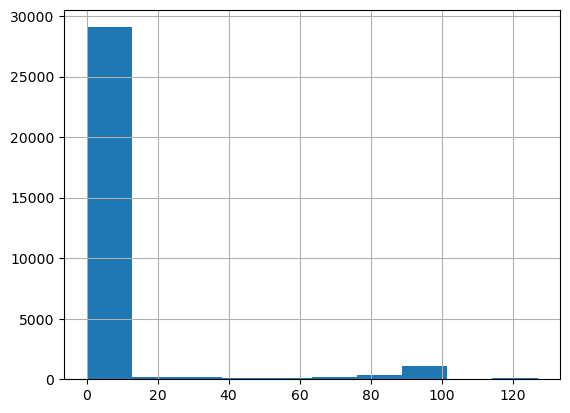

OP5 KBD LEV SCL BRK PT


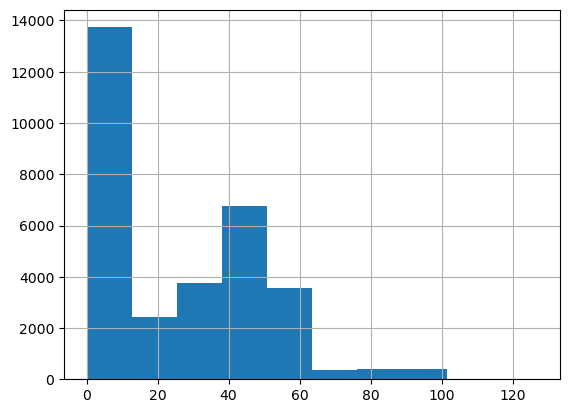

OP5 KBD LEV SCL LFT DEPTH


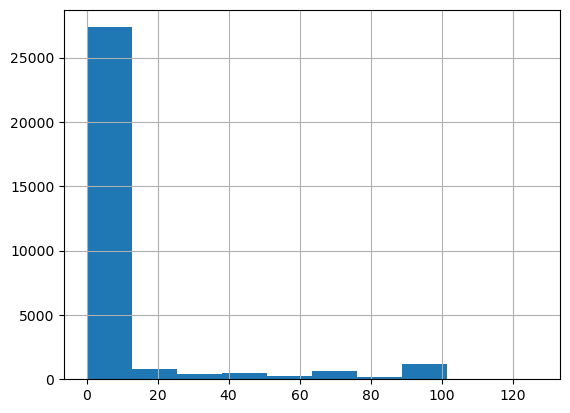

OP5 KBD LEV SCL RHT DEPTH


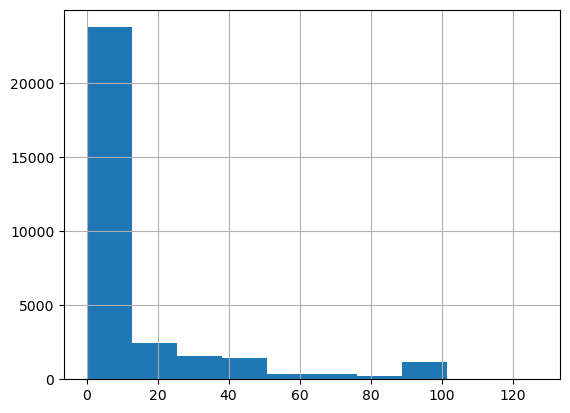

OP5 KBD LEV SCL LFT CURVE


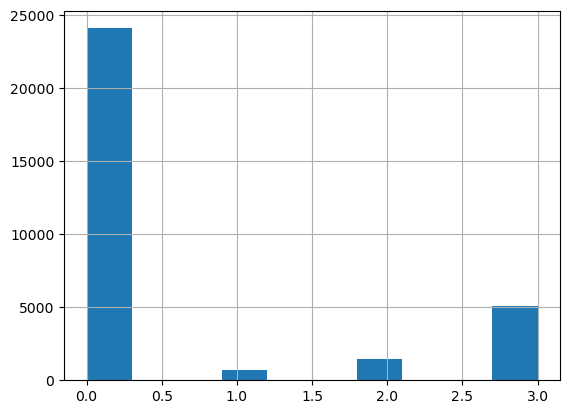

OP5 KBD LEV SCL RHT CURVE


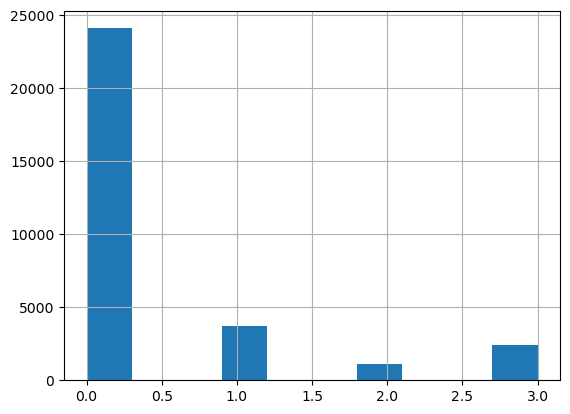

OP5 OSC DETUNE


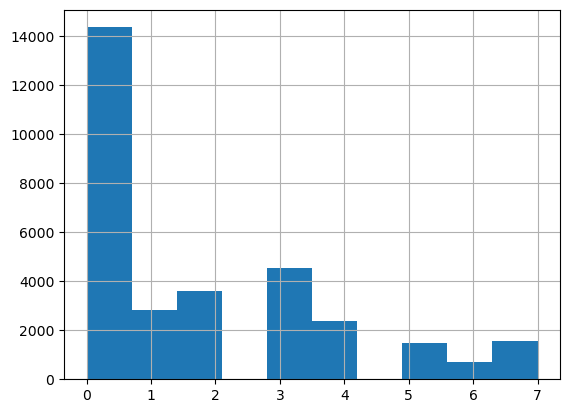

OP5 KBD RATE SCALING


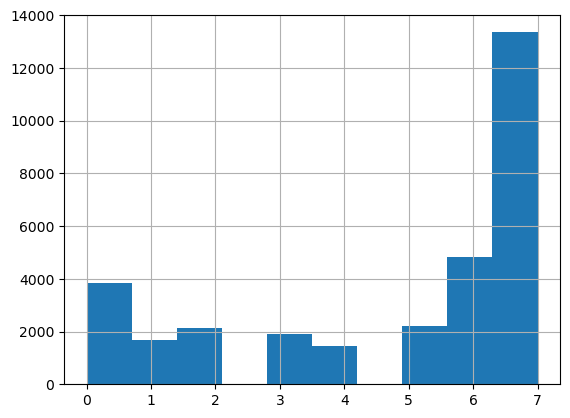

OP5 KEY VEL SENSITIVITY


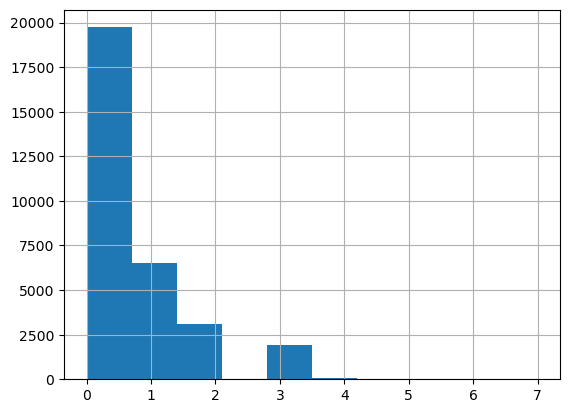

OP5 AMP MOD SENSITIVITY


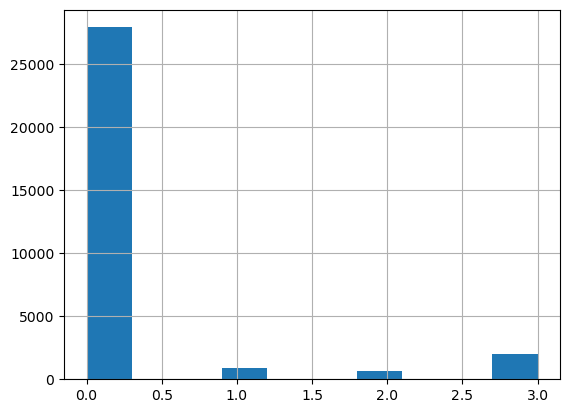

OP5 OPERATOR OUTPUT LEVEL


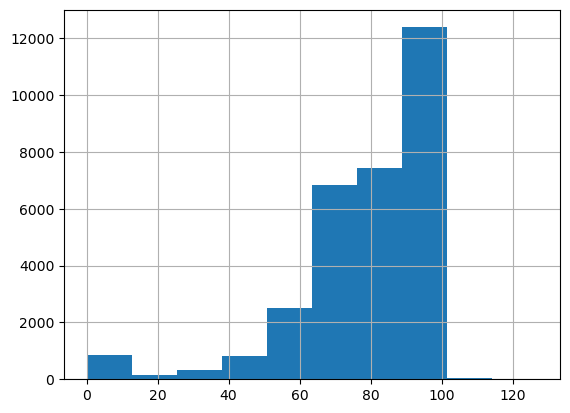

OP5 OSC MODE


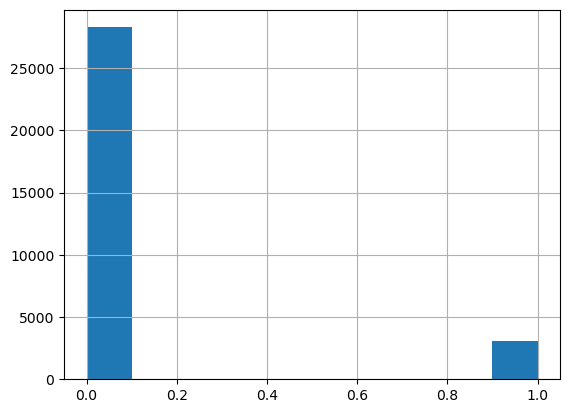

OP5 OSC FREQ COARSE


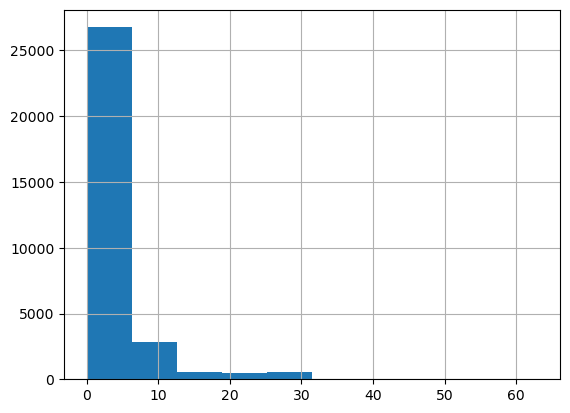

OP5 OSC FREQ FINE


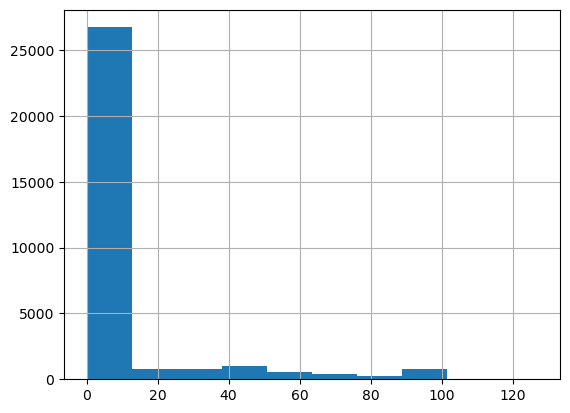

OP4 EG rate 1


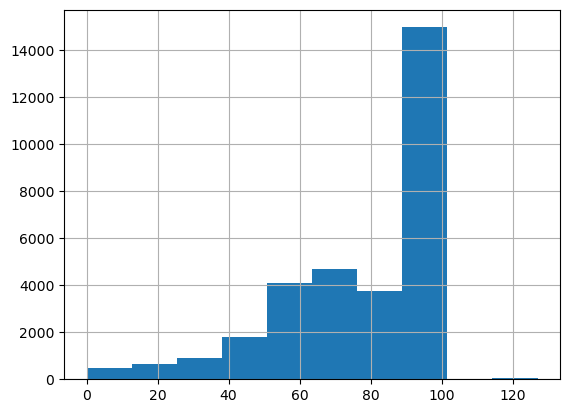

OP4 EG rate 2


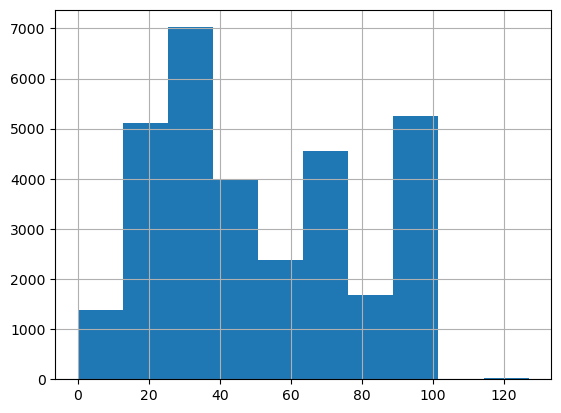

OP4 EG rate 3


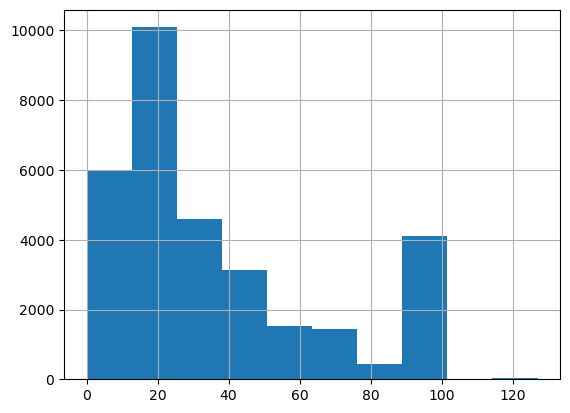

OP4 EG rate 4


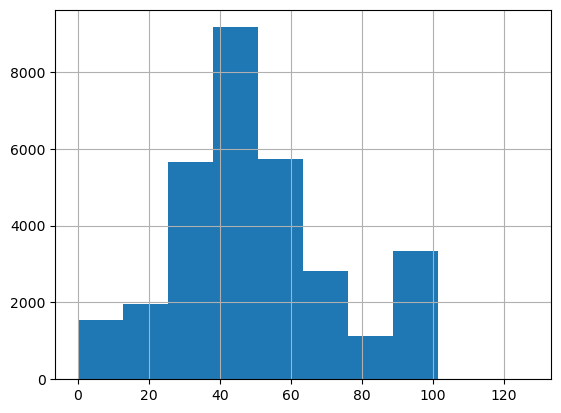

OP4 EG level 1


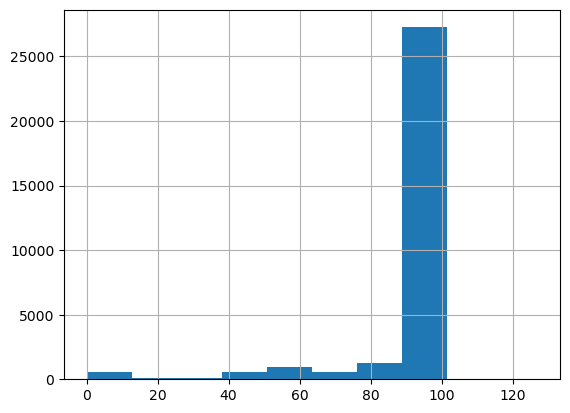

OP4 EG level 2


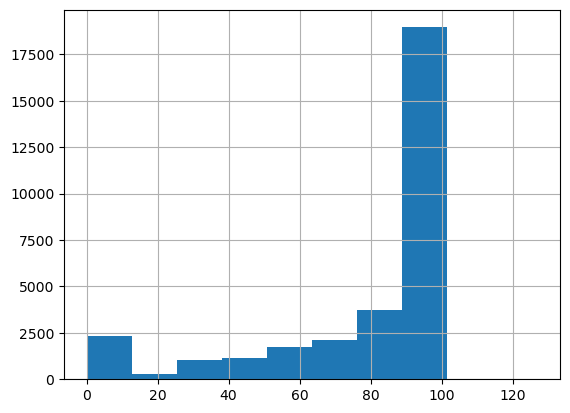

OP4 EG level 3


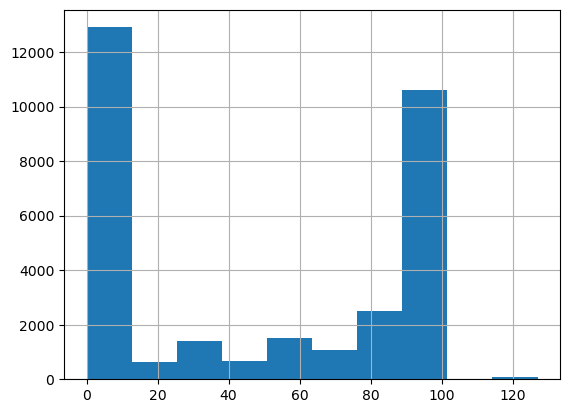

OP4 EG level 4


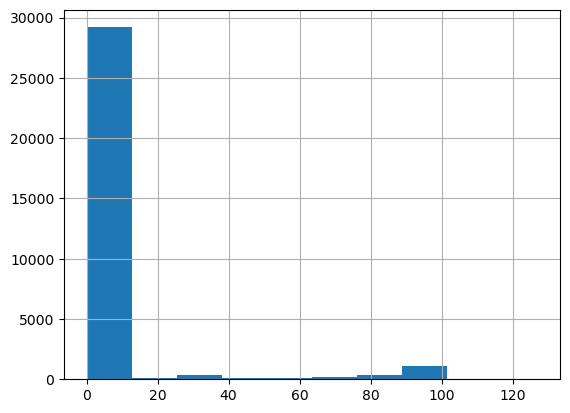

OP4 KBD LEV SCL BRK PT


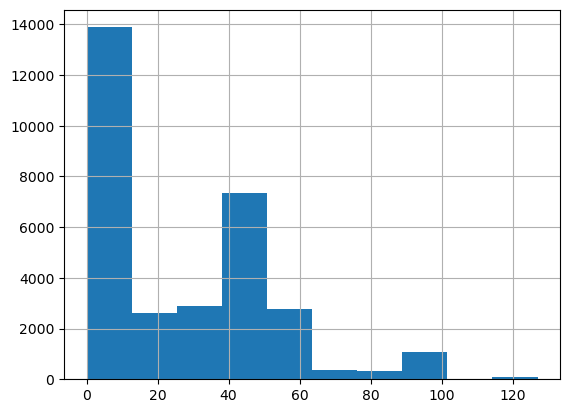

OP4 KBD LEV SCL LFT DEPTH


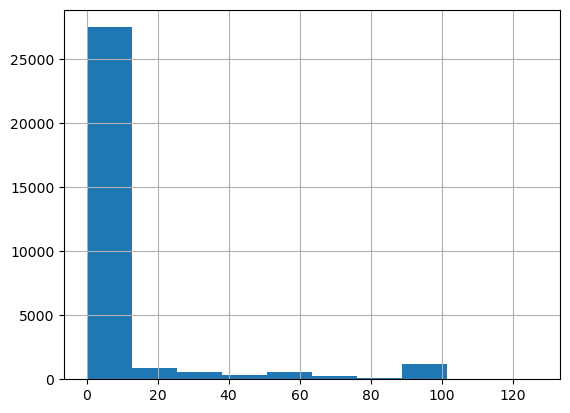

OP4 KBD LEV SCL RHT DEPTH


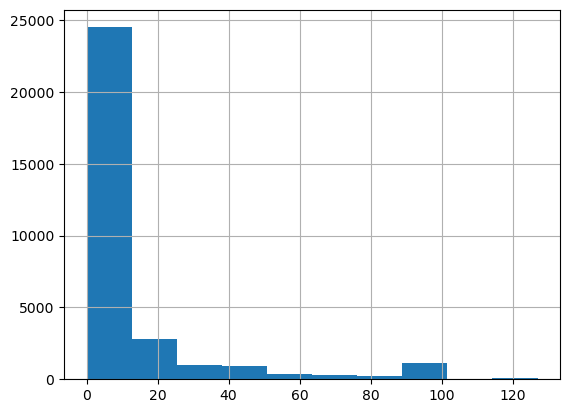

OP4 KBD LEV SCL LFT CURVE


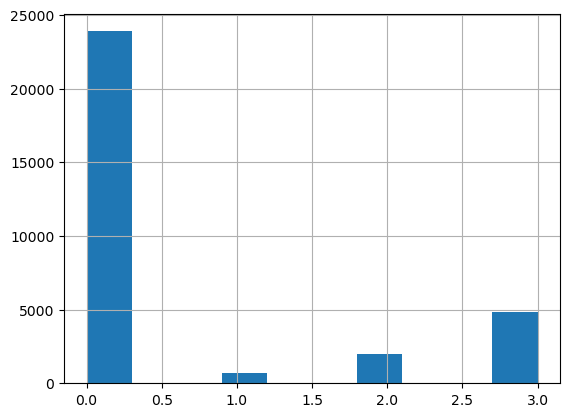

OP4 KBD LEV SCL RHT CURVE


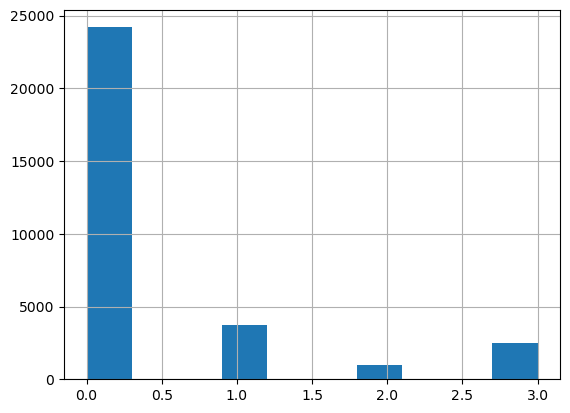

OP4 OSC DETUNE


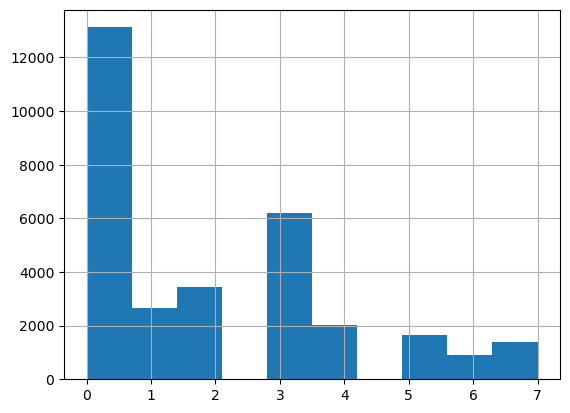

OP4 KBD RATE SCALING


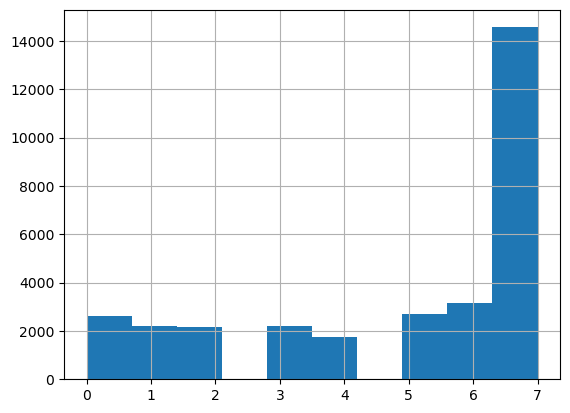

OP4 KEY VEL SENSITIVITY


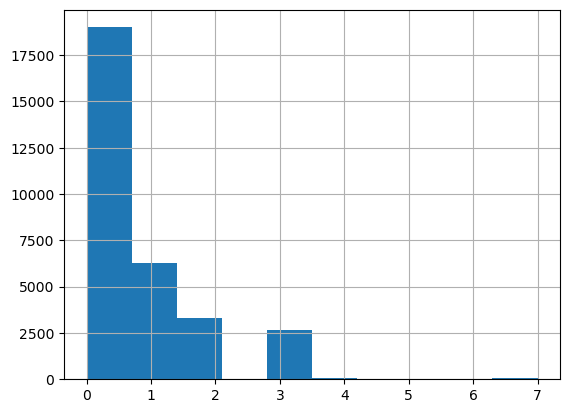

OP4 AMP MOD SENSITIVITY


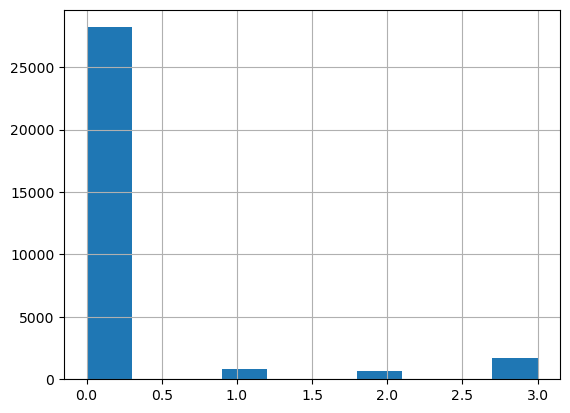

OP4 OPERATOR OUTPUT LEVEL


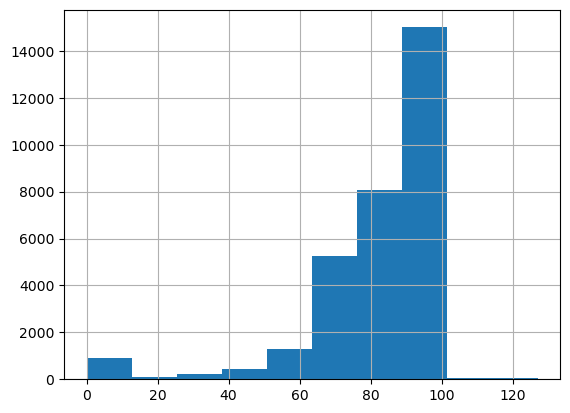

OP4 OSC MODE


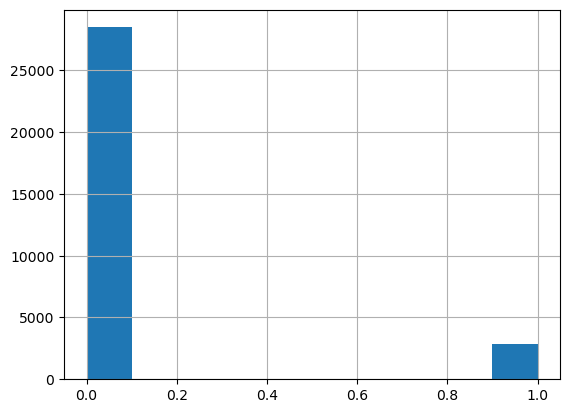

OP4 OSC FREQ COARSE


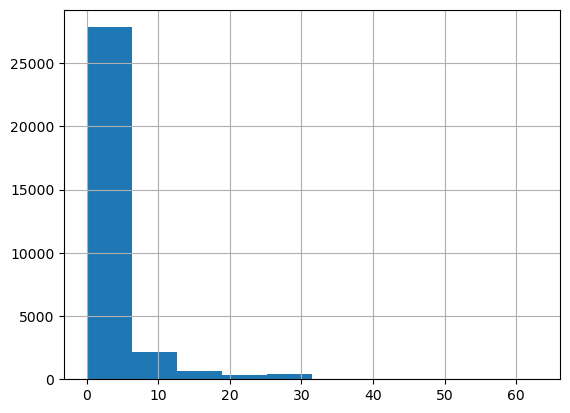

OP4 OSC FREQ FINE


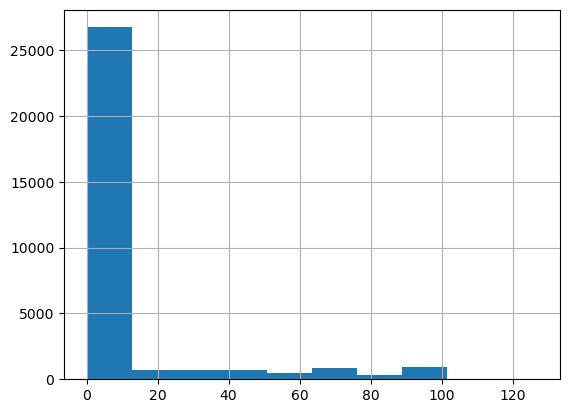

OP3 EG rate 1


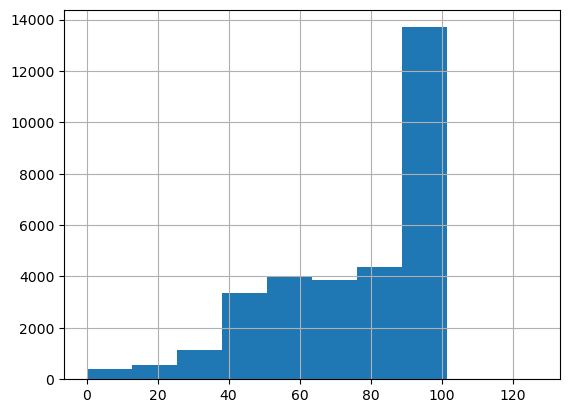

OP3 EG rate 2


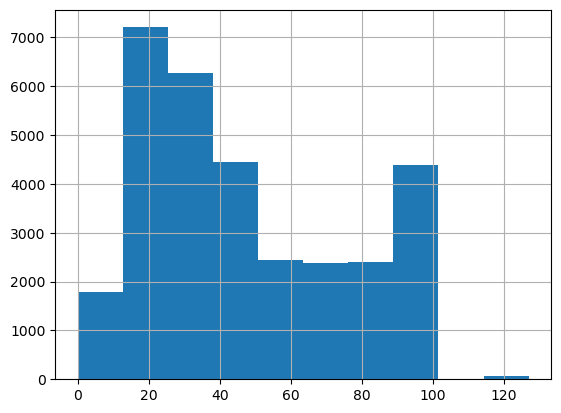

OP3 EG rate 3


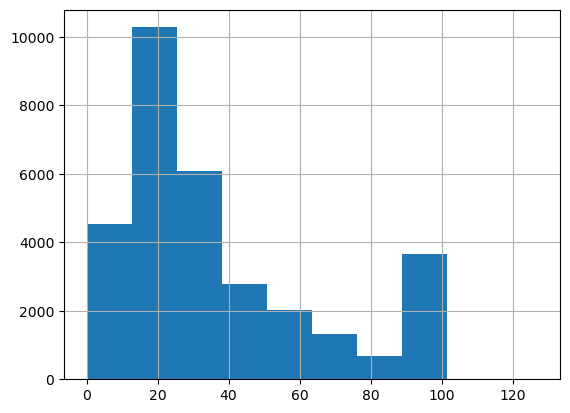

OP3 EG rate 4


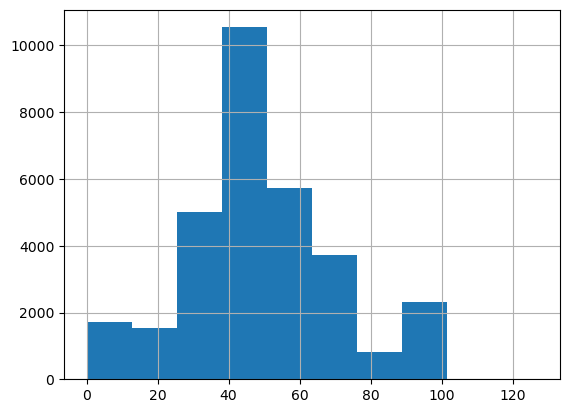

OP3 EG level 1


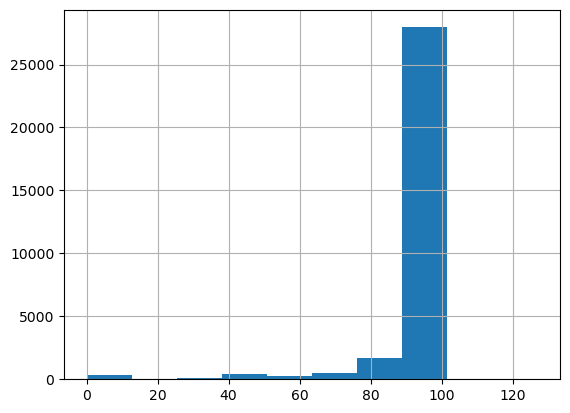

OP3 EG level 2


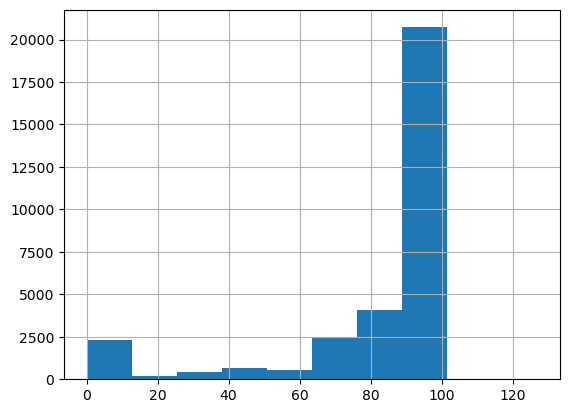

OP3 EG level 3


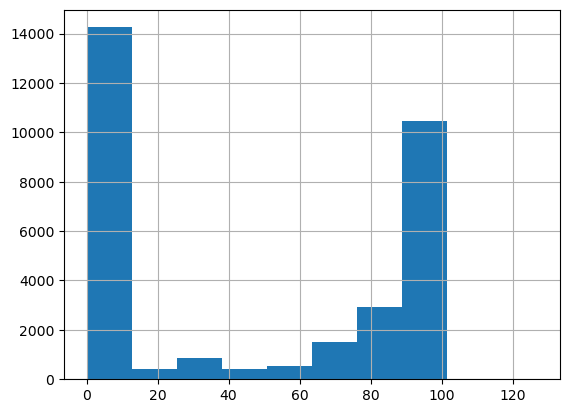

OP3 EG level 4


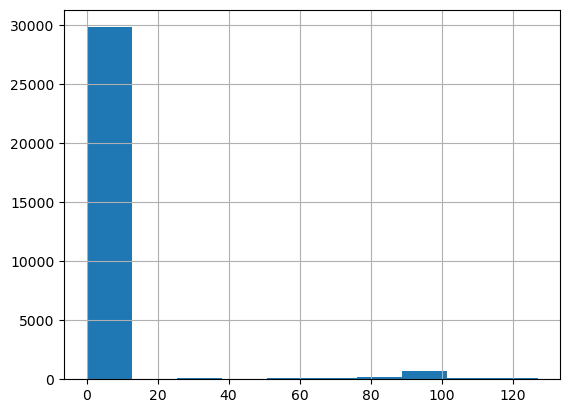

OP3 KBD LEV SCL BRK PT


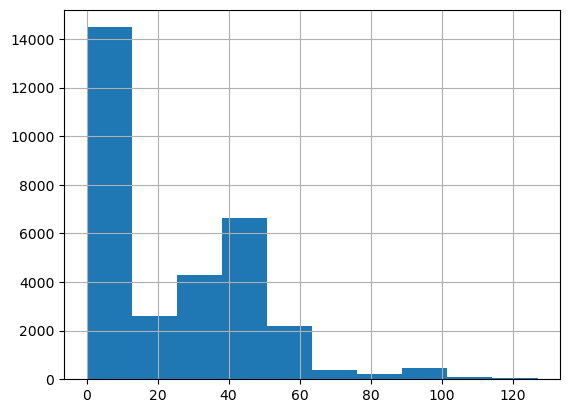

OP3 KBD LEV SCL LFT DEPTH


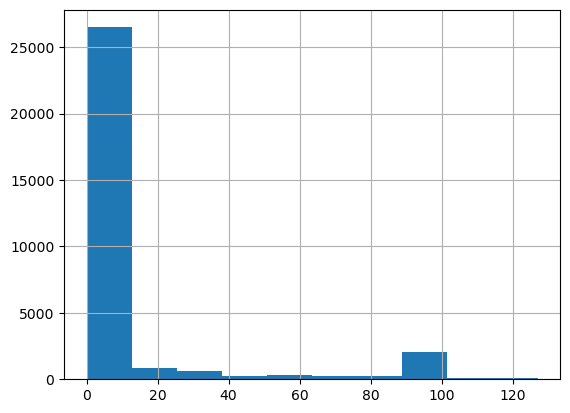

OP3 KBD LEV SCL RHT DEPTH


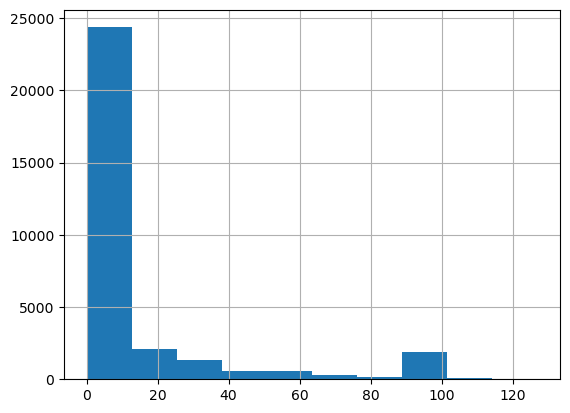

OP3 KBD LEV SCL LFT CURVE


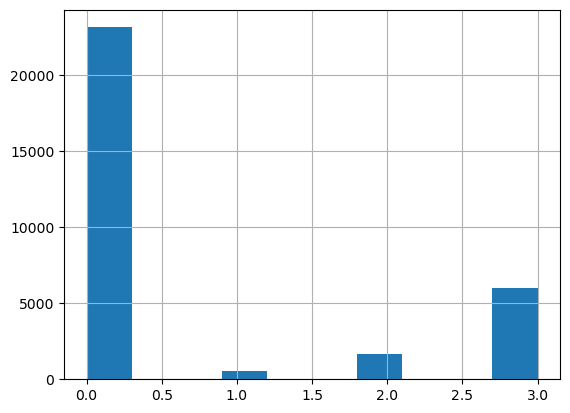

OP3 KBD LEV SCL RHT CURVE


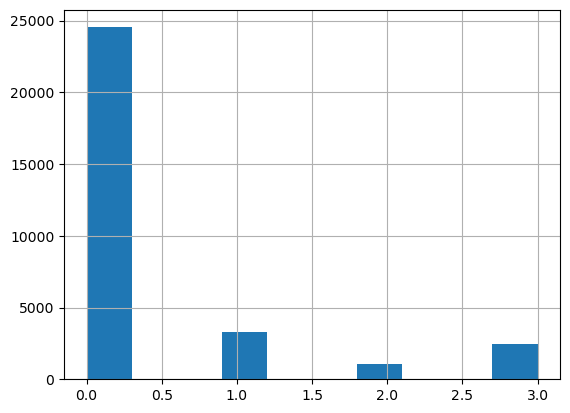

OP3 OSC DETUNE


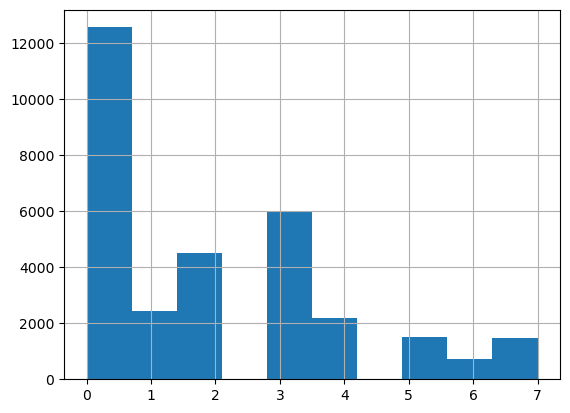

OP3 KBD RATE SCALING


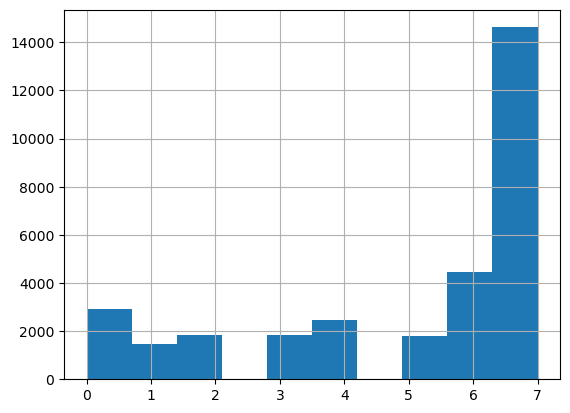

OP3 KEY VEL SENSITIVITY


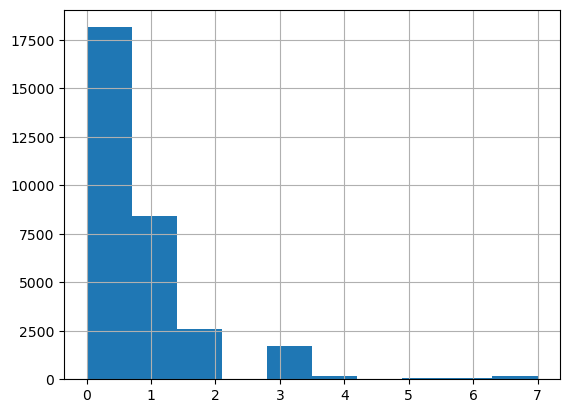

OP3 AMP MOD SENSITIVITY


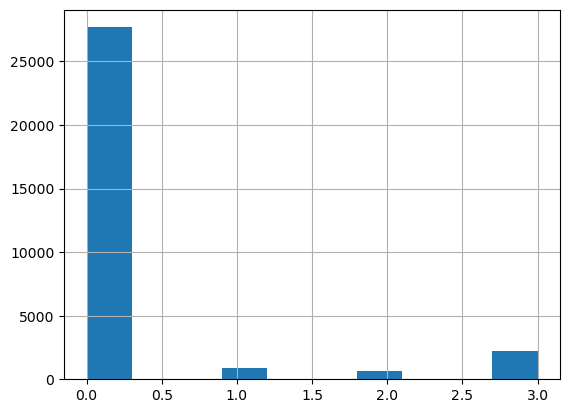

OP3 OPERATOR OUTPUT LEVEL


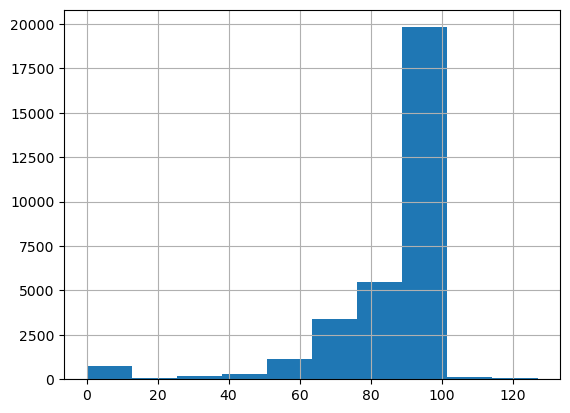

OP3 OSC MODE


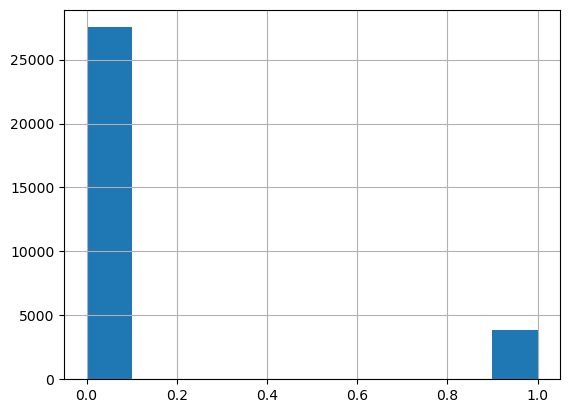

OP3 OSC FREQ COARSE


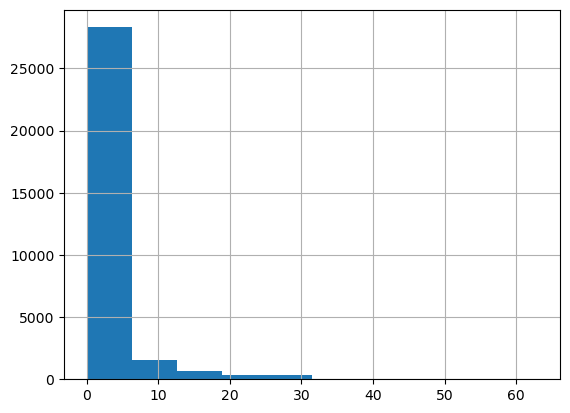

OP3 OSC FREQ FINE


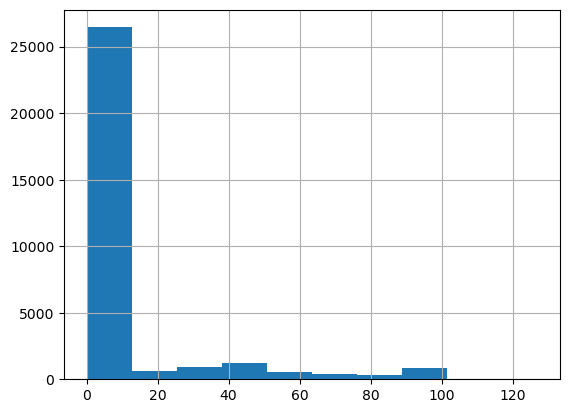

OP2 EG rate 1


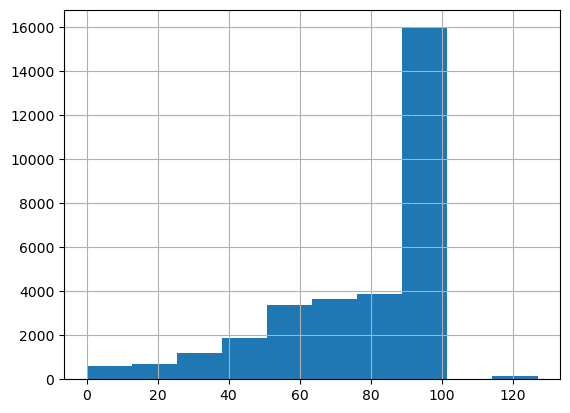

OP2 EG rate 2


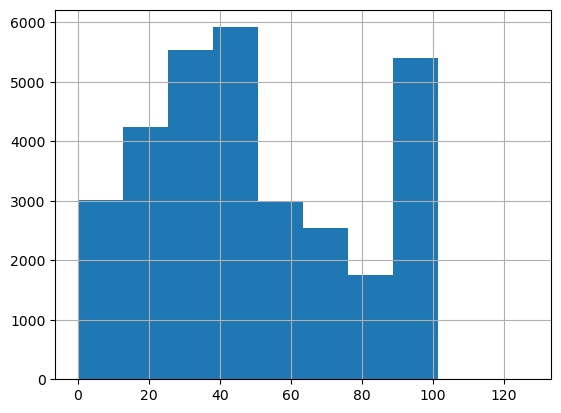

OP2 EG rate 3


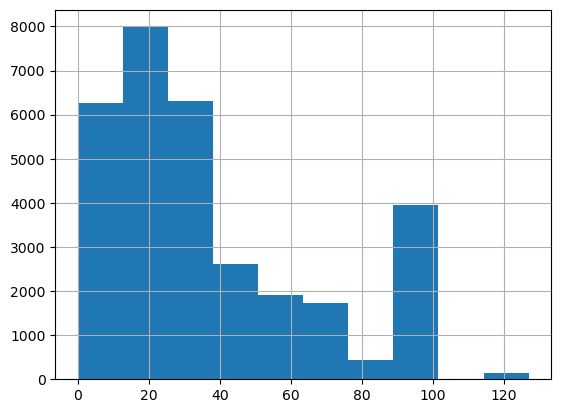

OP2 EG rate 4


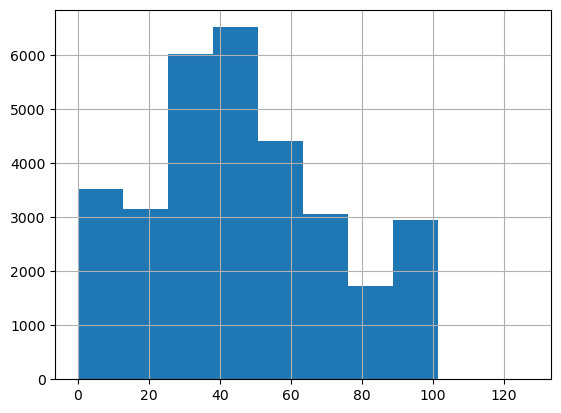

OP2 EG level 1


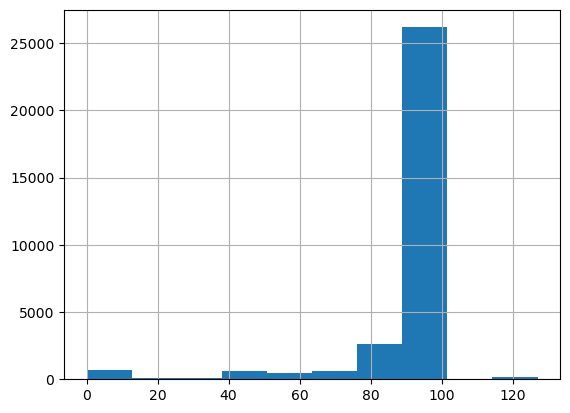

OP2 EG level 2


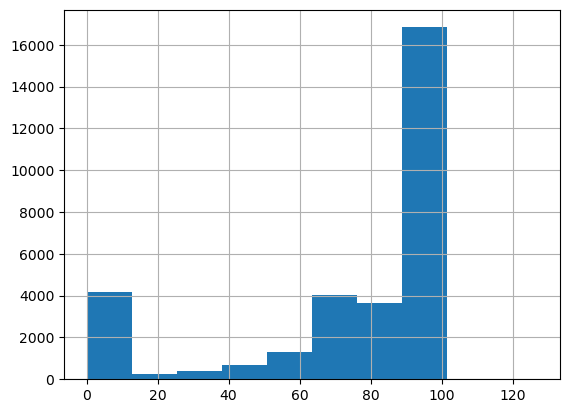

OP2 EG level 3


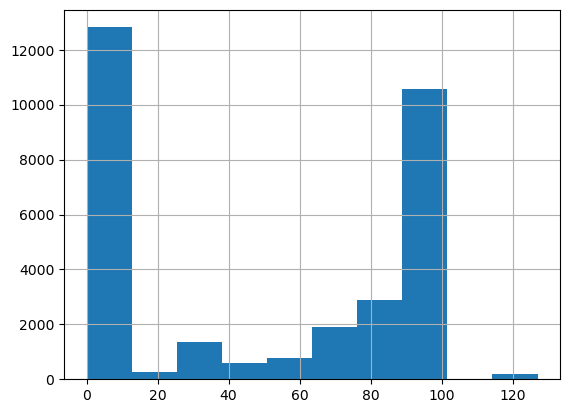

OP2 EG level 4


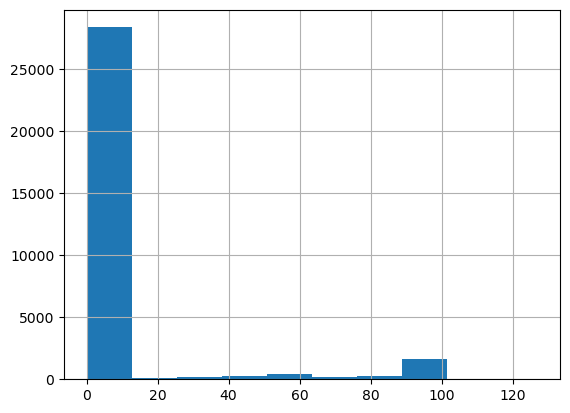

OP2 KBD LEV SCL BRK PT


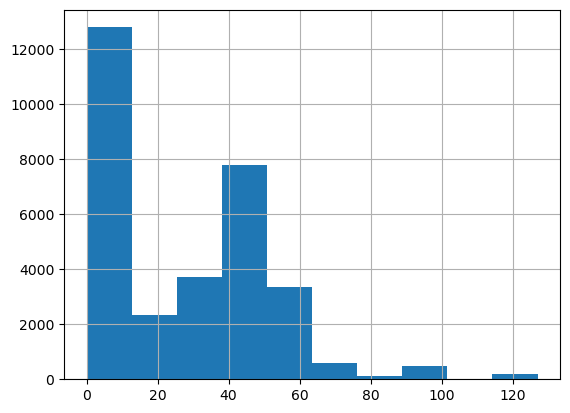

OP2 KBD LEV SCL LFT DEPTH


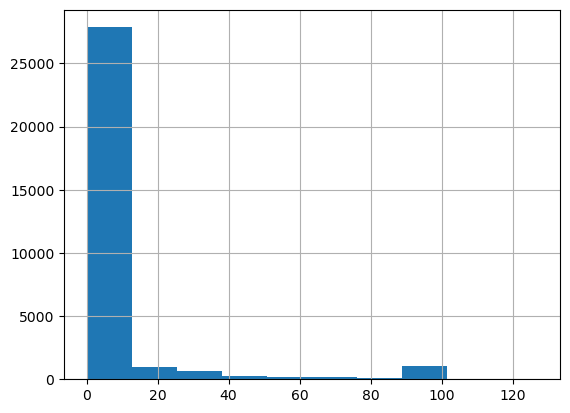

OP2 KBD LEV SCL RHT DEPTH


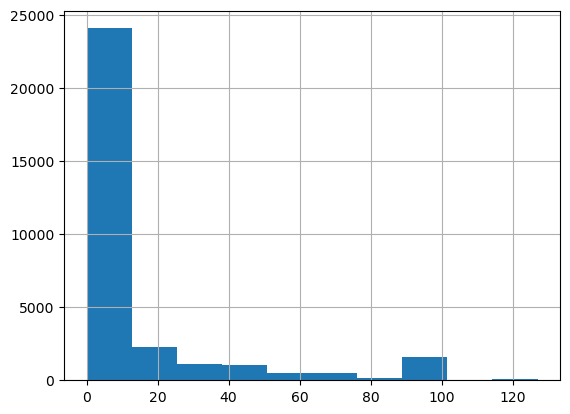

OP2 KBD LEV SCL LFT CURVE


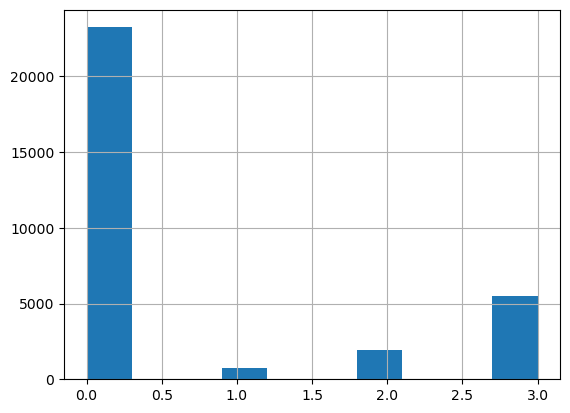

OP2 KBD LEV SCL RHT CURVE


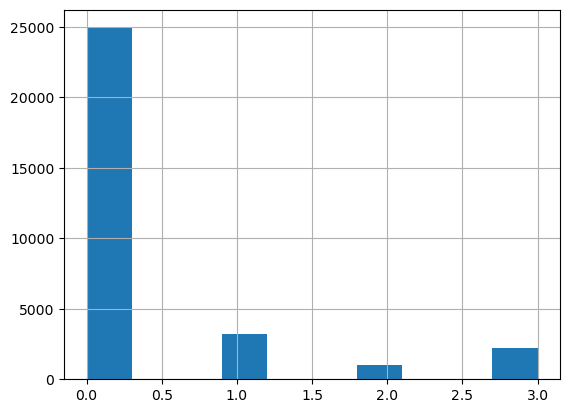

OP2 OSC DETUNE


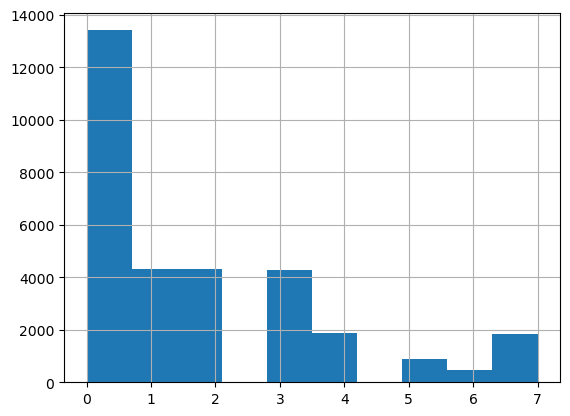

OP2 KBD RATE SCALING


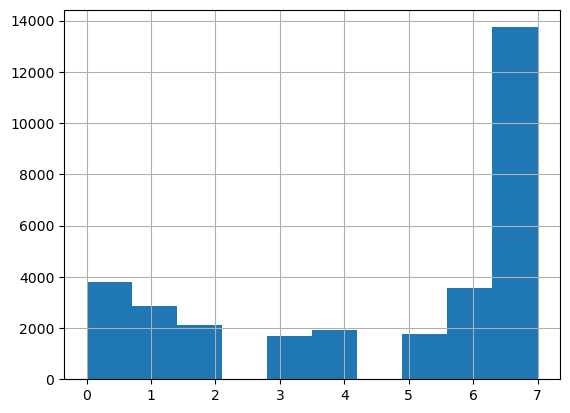

OP2 KEY VEL SENSITIVITY


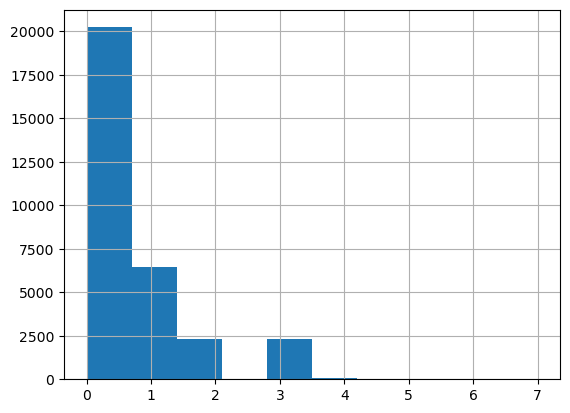

OP2 AMP MOD SENSITIVITY


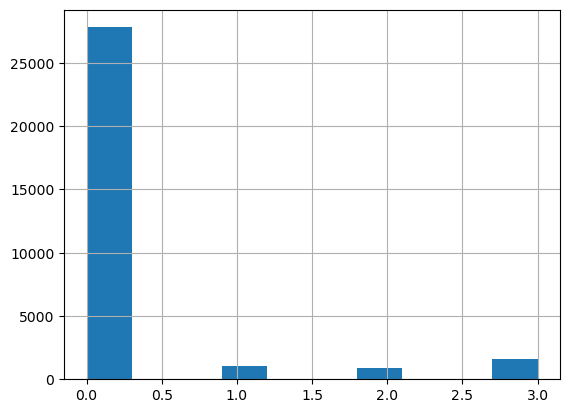

OP2 OPERATOR OUTPUT LEVEL


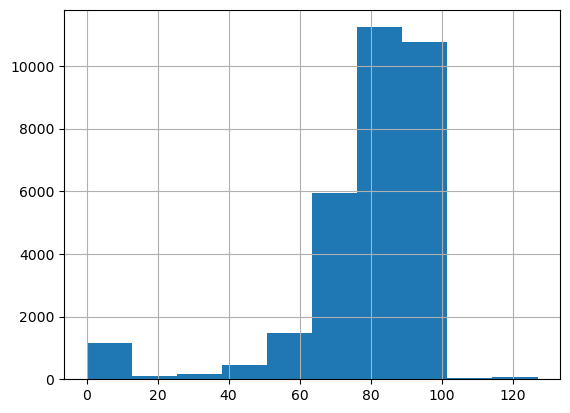

OP2 OSC MODE


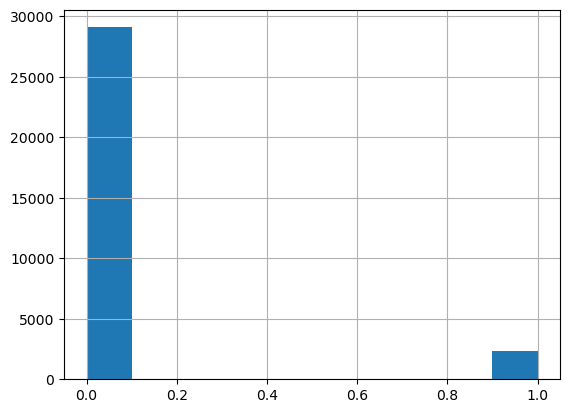

OP2 OSC FREQ COARSE


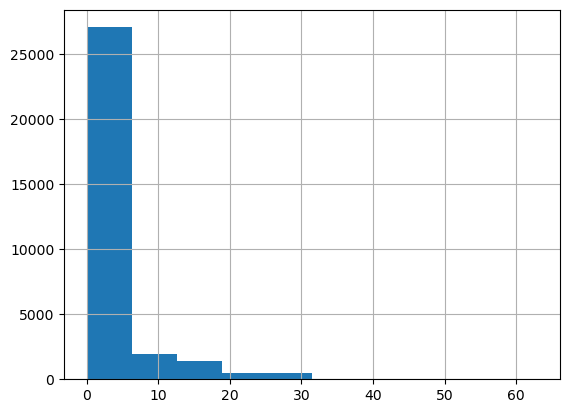

OP2 OSC FREQ FINE


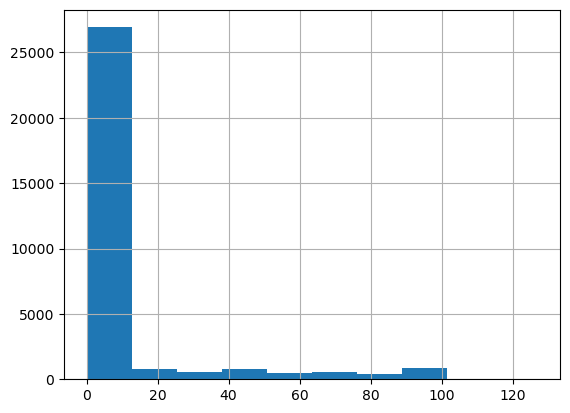

OP1 EG rate 1


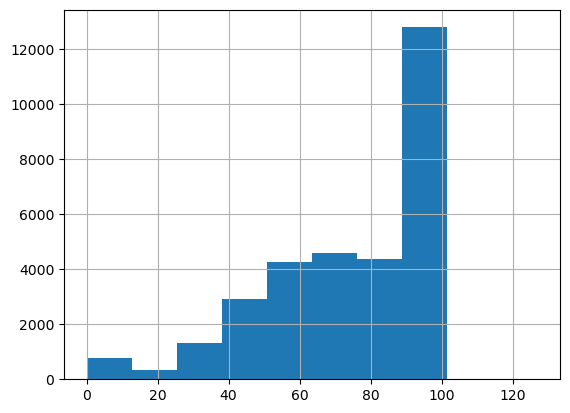

OP1 EG rate 2


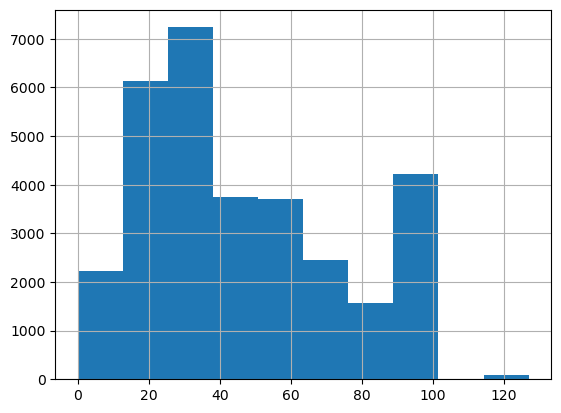

OP1 EG rate 3


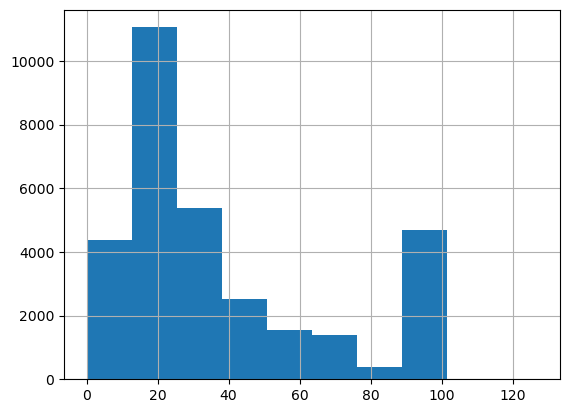

OP1 EG rate 4


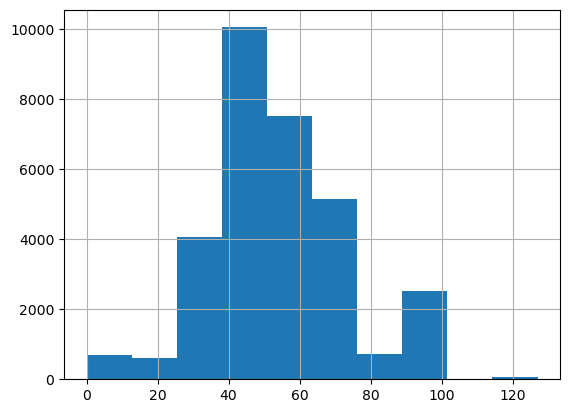

OP1 EG level 1


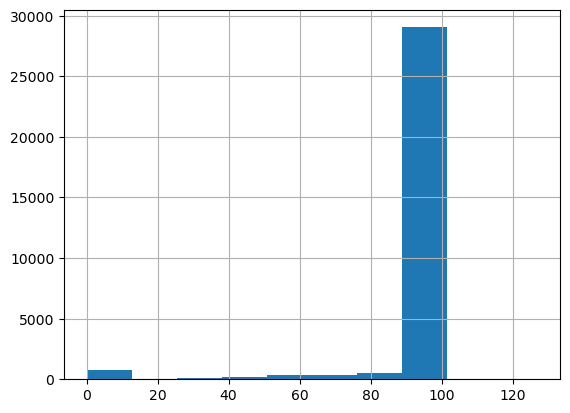

OP1 EG level 2


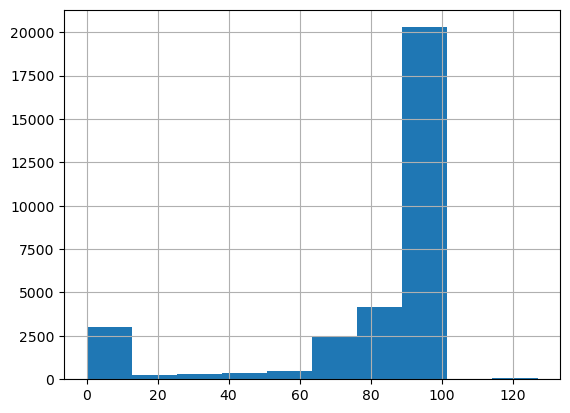

OP1 EG level 3


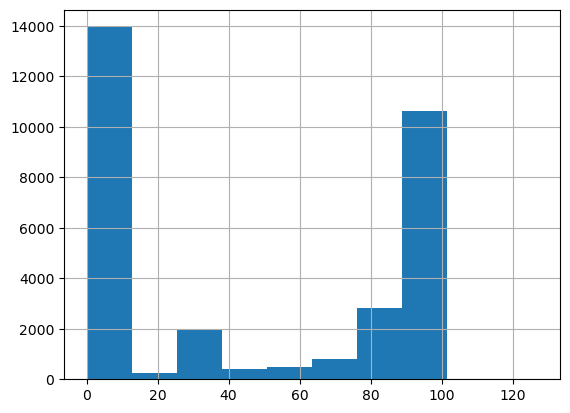

OP1 EG level 4


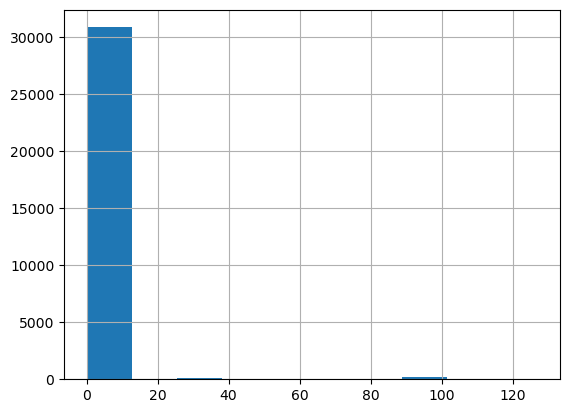

OP1 KBD LEV SCL BRK PT


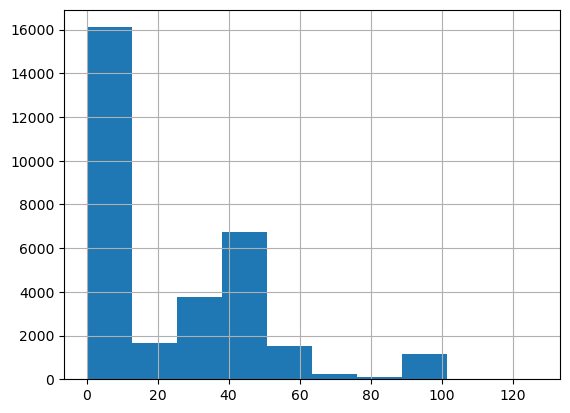

OP1 KBD LEV SCL LFT DEPTH


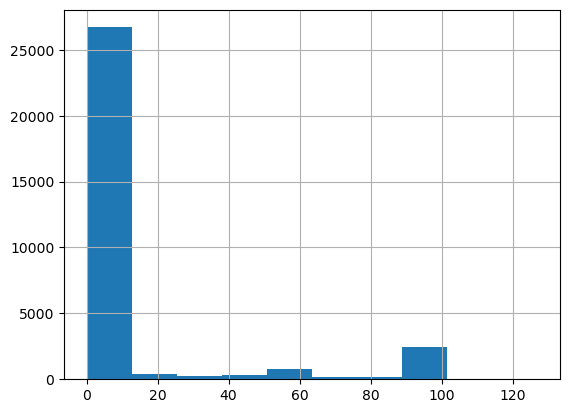

OP1 KBD LEV SCL RHT DEPTH


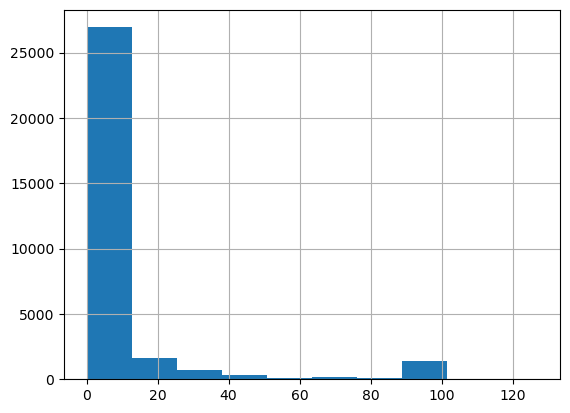

OP1 KBD LEV SCL LFT CURVE


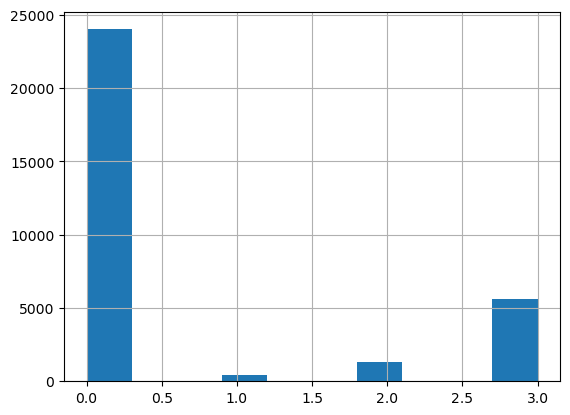

OP1 KBD LEV SCL RHT CURVE


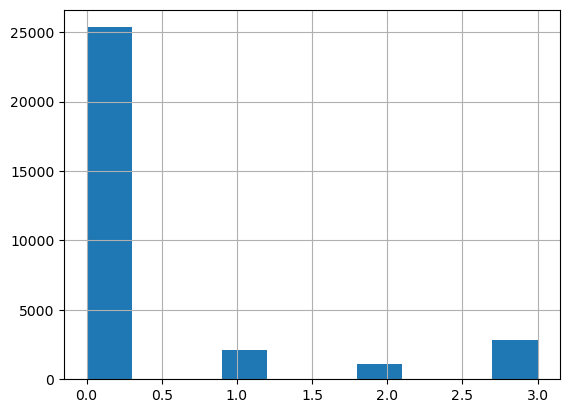

OP1 OSC DETUNE


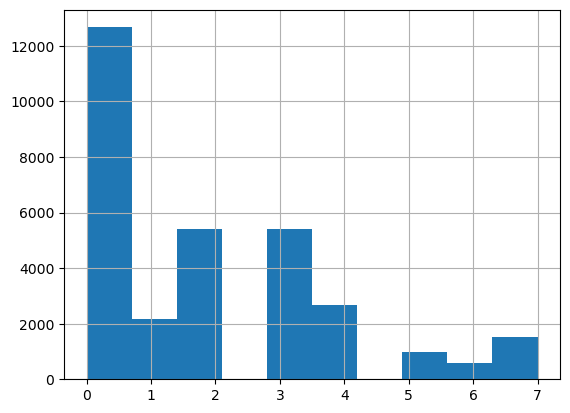

OP1 KBD RATE SCALING


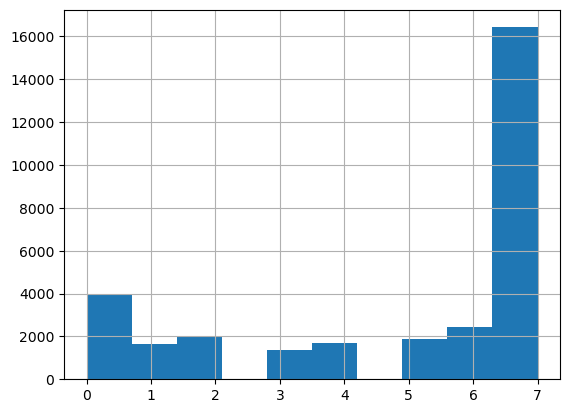

OP1 KEY VEL SENSITIVITY


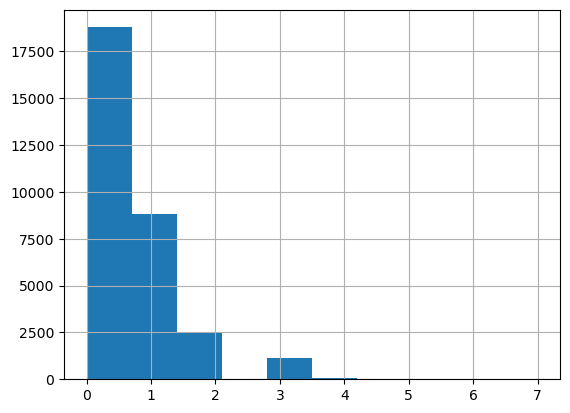

OP1 AMP MOD SENSITIVITY


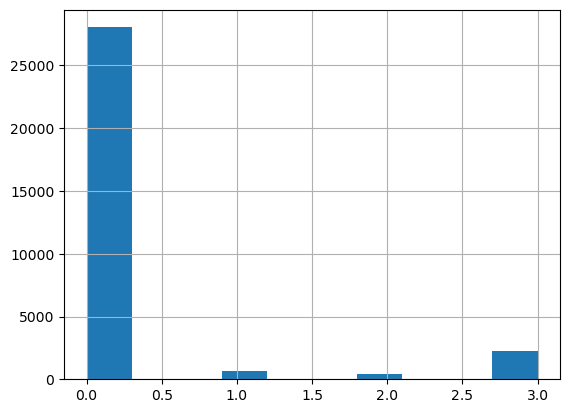

OP1 OPERATOR OUTPUT LEVEL


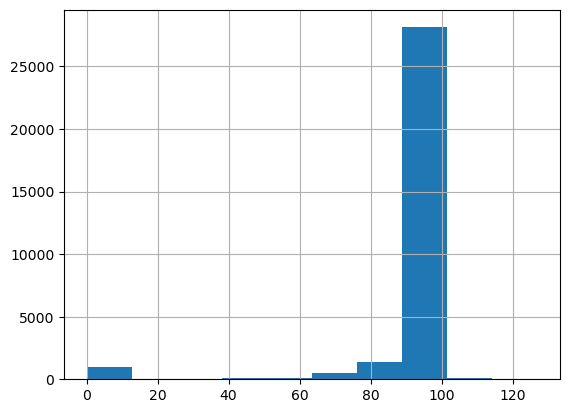

OP1 OSC MODE


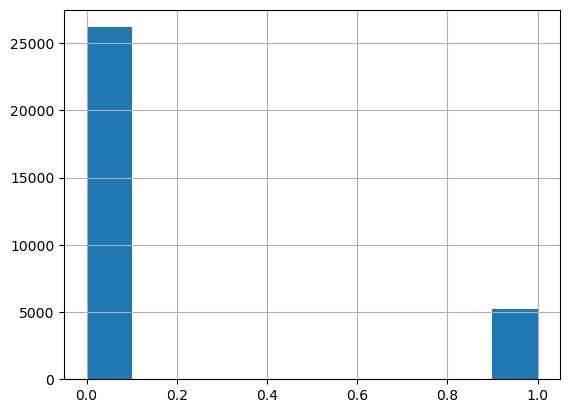

OP1 OSC FREQ COARSE


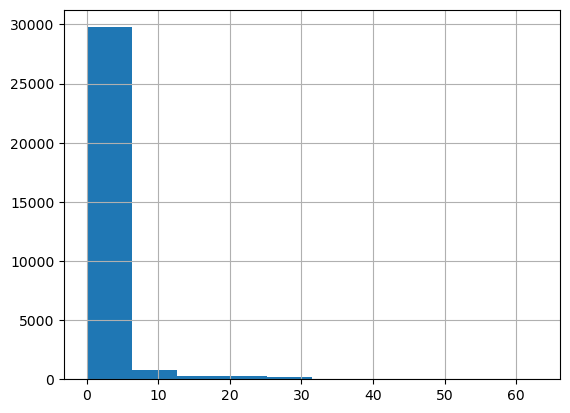

OP1 OSC FREQ FINE


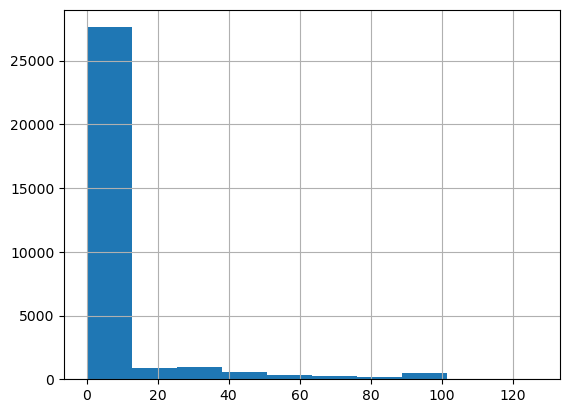

PITCH EG rate 1


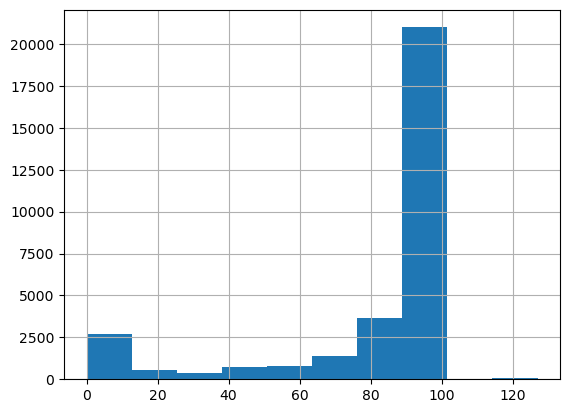

PITCH EG rate 2


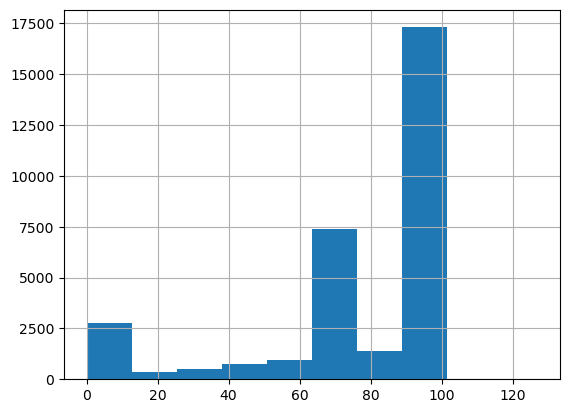

PITCH EG rate 3


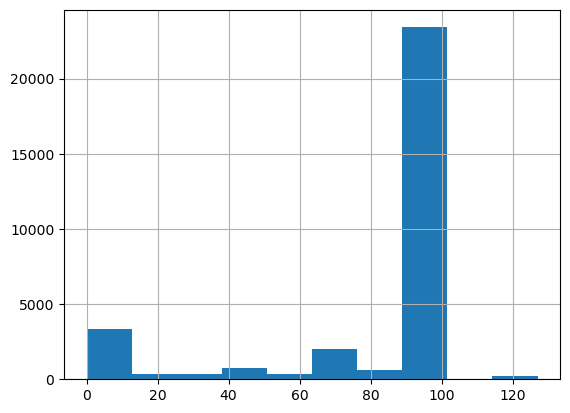

PITCH EG rate 4


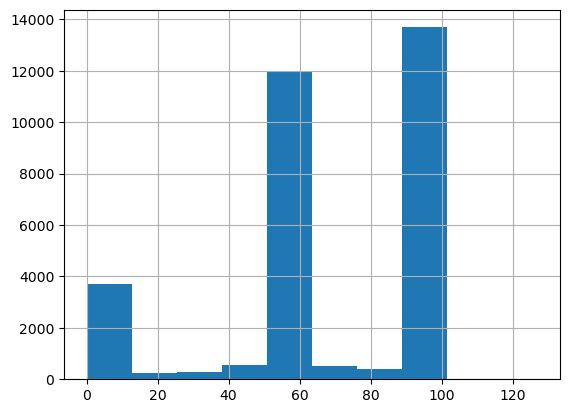

PITCH EG level 1


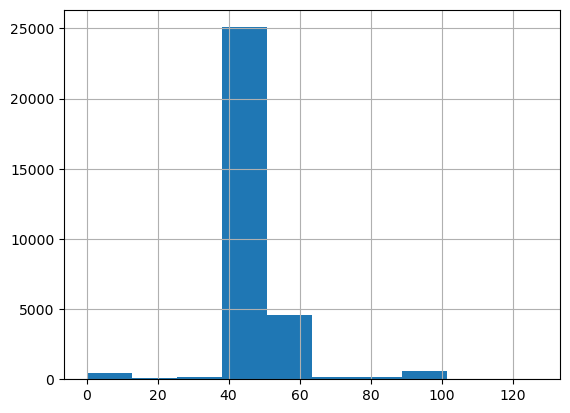

PITCH EG level 2


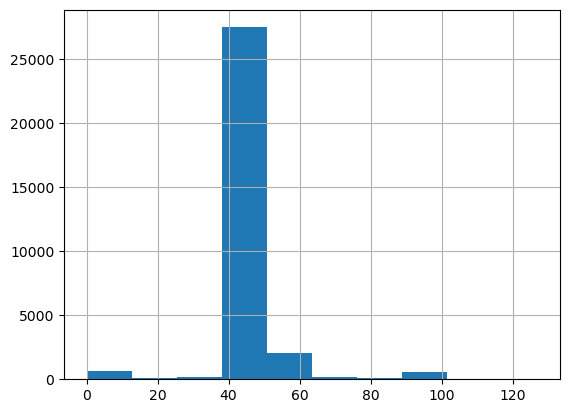

PITCH EG level 3


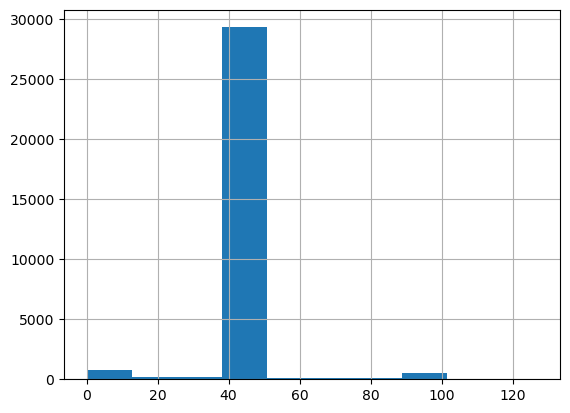

PITCH EG level 4


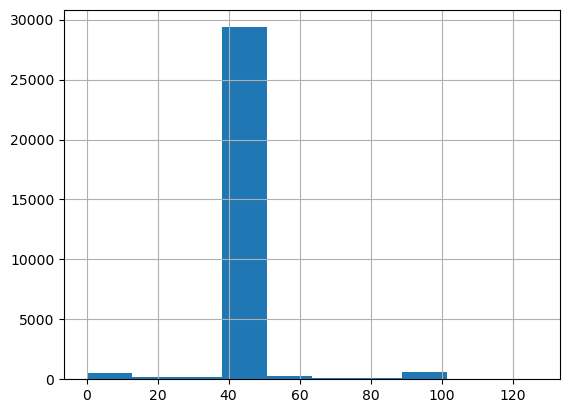

ALGORITHM #


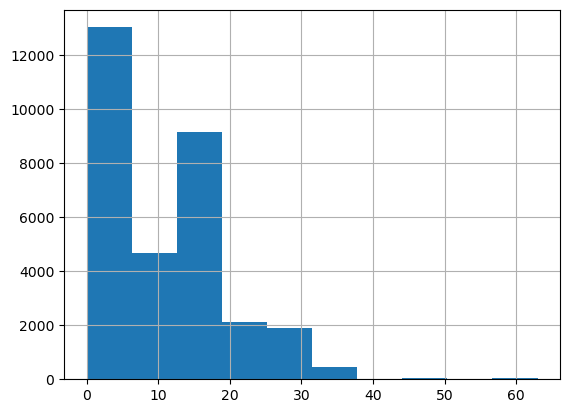

OSCILLATOR SYNC


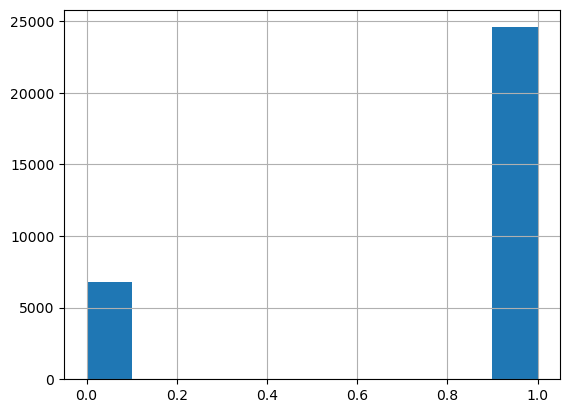

FEEDBACK


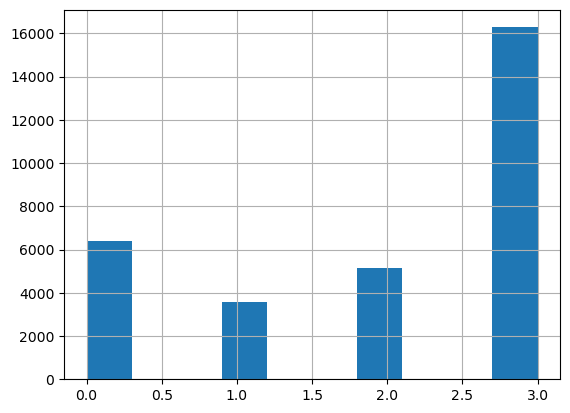

LFO SPEED


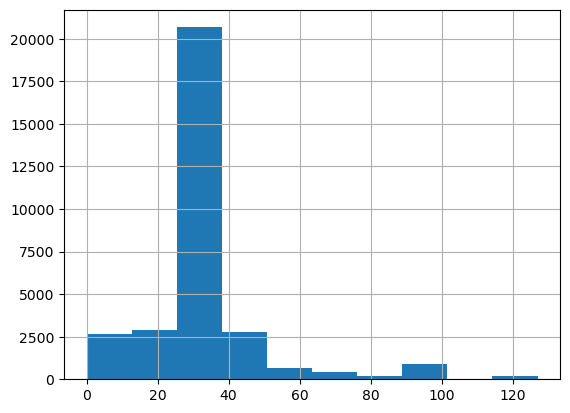

LFO DELAY


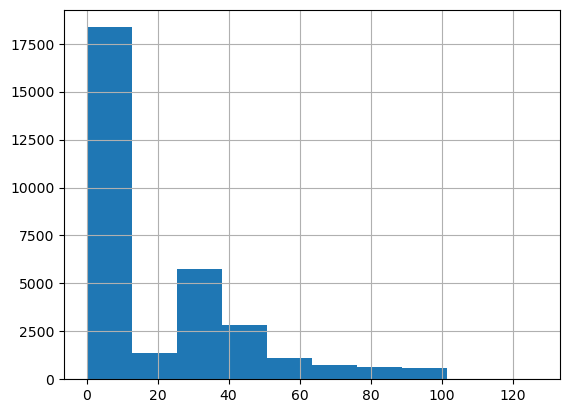

LFO PITCH MOD DEPTH


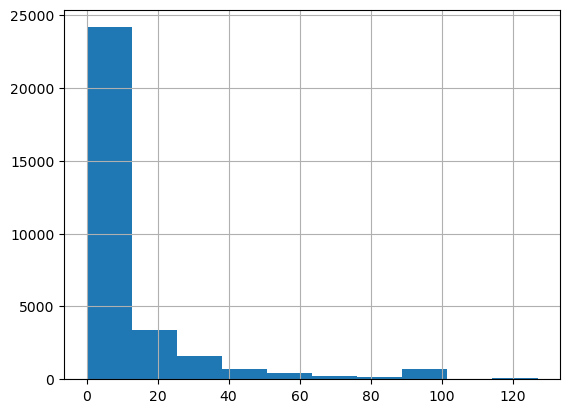

LFO AMP MOD DEPTH


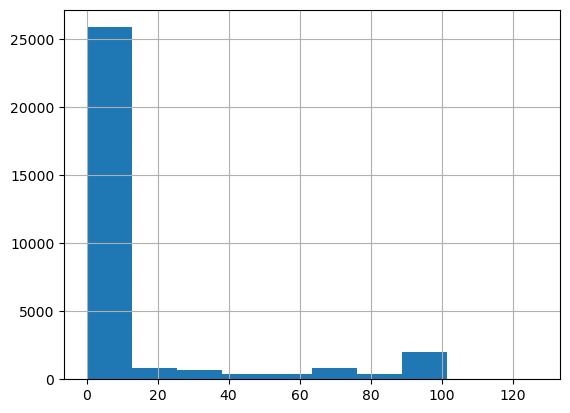

LFO SYNC


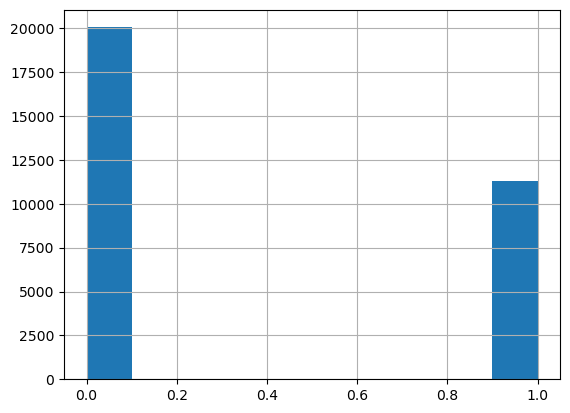

LFO WAVEFORM


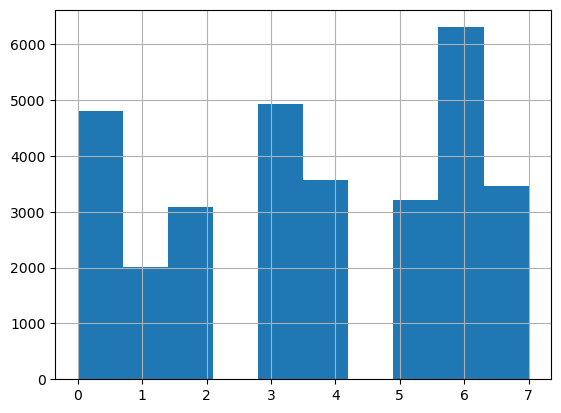

PITCH MOD SENSITIVITY


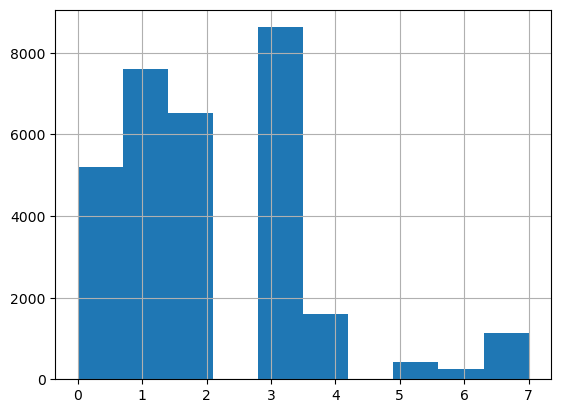

TRANSPOSE


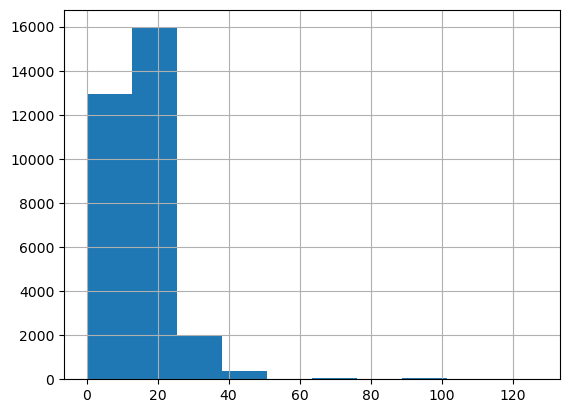

VOICE NAME


/Users/maxhenry/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maxhenry/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maxhenry/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 15 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maxhenry/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 6 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maxhenry/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maxhenry/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWa

ValueError: 
$$String$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

In [383]:
df = generate_dataset(fpath)
df = pd.DataFrame(df)
for key in df.keys():
    print(key)
    df[key].hist()
    plt.show()

In [354]:
p_train = 0.8
batch_size = 128

n_train = int(p_train * len(dataset))
n_val = len(dataset) - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [355]:
dimensions = [128, 128, 64, 64, 64, 32, 32, 32, 32]
model_type = 'ae'

n_features = len(dataset._parameter_names)
n_latent = dimensions[-1]

if model_type == 'ae':
    model = AE(n_features, *dimensions)
elif model_type == 'vae':
    model = VAE(n_features, *dimensions)

model = model.to(device)

Epoch 0
Trn: 0.00456759	Val: 0.00449090



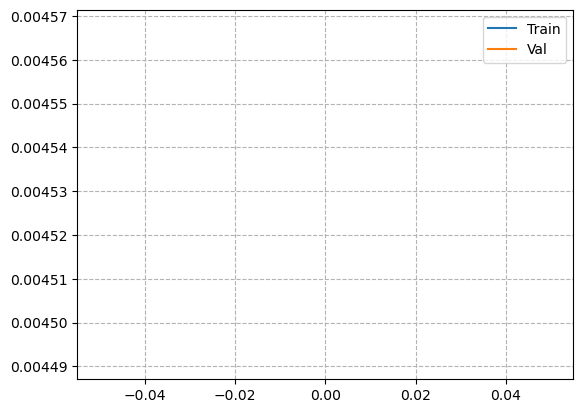

Saved checkpoint at: checkpoints/chkpnt_20231029_125814_epoch0.pt


In [337]:
# Training.
n_epochs = 1
lr = 1e-3

checkpoint_dir = 'checkpoints/'
save_interval_epochs = 10
plot_interval_epochs = 25

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

best_loss = np.inf
train_loss = []
val_loss = []
for i in range(n_epochs):
    epoch_train_loss = train_one_epoch(model, train_loader, optimizer, device, model_type)
    epoch_val_loss = validate(model, val_loader, device, model_type)
    scheduler.step(epoch_val_loss)

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

    clear_output(wait=True)

    print(f"Epoch {i}")
    print_loss_metrics(epoch_train_loss, epoch_val_loss)

    if i % plot_interval_epochs == 0:
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.legend()
        plt.show()


    if i % save_interval_epochs != 0:
        continue

    if epoch_val_loss < best_loss:
        fname = f"chkpnt_{get_date_and_time()}_epoch{i}.pt"
        fpath = os.path.join(checkpoint_dir, fname)

        save_checkpoint(model, optimizer, fpath)

        print("=" * 80)
        print(f"Saved checkpoint at: {fpath}")
        print("=" * 80)

        best_loss = epoch_val_loss

In [356]:
# fpath = 'checkpoints/chkpnt_20231018_063837_epoch490.pt'
# load_checkpoint(fpath, model, optimizer)
model.eval()

restore = dataset.get_restorer()

# Sample first 16 patches and their reconstructions.
patches = []
with torch.no_grad():
    for i, x in enumerate(dataset):
        x = x.to(device)

        if model_type == 'vae':
            y, mu, log_var = model(x)
        elif model_type == 'ae':
            y, z = model(x)

        x = x.to('cpu')
        y = y.to('cpu')

        x = restore(x)
        y = restore(y)

        x = onehot_decode(x)
        y = onehot_decode(y)

        x['VOICE NAME'] = f"x{i}"
        y['VOICE NAME'] = f"y{i}"

        patches.append(x)
        patches.append(y)

        if i >= 15:
            break

In [357]:
from chatgpt_util_imports import make_cartridge

fpath = "data/test.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)

In [358]:
# fpath = 'checkpoints/chkpnt_20231018_063837_epoch490.pt'
# load_checkpoint(fpath, model, optimizer)

embeddings = collect_embeddings(model, dataset, device, model_type)

In [135]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
result = pca.fit_transform(embeddings)

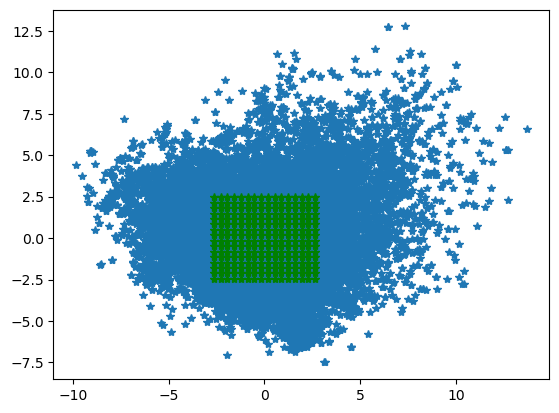

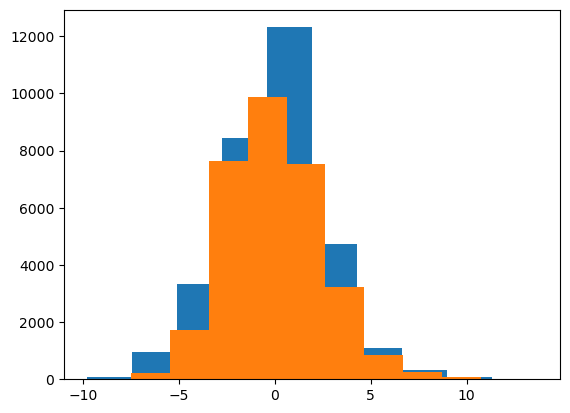

In [137]:
means = np.mean(result, axis=0)
stds = np.std(result, axis=0)

mins = means - stds
maxs = means + stds

n_steps = 16

grid = np.empty((n_steps, n_components))

for i in range(n_components):
    grid[:, i] = np.linspace(mins[i], maxs[i], n_steps)

plt.plot(result[:, 0], result[:, 1], '*')
for i in range(n_steps):
    plt.plot(grid[:, 0], grid[i, 1].repeat(n_steps), '*g')
plt.show()

plt.hist(result[:, 0])
plt.hist(result[:, 1])
plt.show()

In [138]:
grid_embeddings = np.empty((n_steps, n_steps, n_latent))

for i in range(n_steps):
    for j in range(n_steps):
        z = pca.inverse_transform((grid[i, 0], grid[j, 1]))
        grid_embeddings[i, j, :] = z

In [143]:
patches = []
middle_idx = n_steps // 2 - 1

with torch.no_grad():
    for i in range(n_steps):
        z = grid_embeddings[i, middle_idx, :]
        z = torch.Tensor(z).to(device)

        x = model.decode(z).cpu()
        x = restore(x)
        x = onehot_decode(x)

        x['VOICE NAME'] = f"{i}, {middle_idx}"

        patches.append(x)
    for i in range(n_steps):
        z = grid_embeddings[middle_idx, i, :]
        z = torch.Tensor(z).to(device)

        x = model.decode(z).cpu()
        x = restore(x)
        x = onehot_decode(x)

        x['VOICE NAME'] = f"{middle_idx}, {i}"
        patches.append(x)

In [144]:
fpath = "data/pca_grid.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)